In [82]:
from sklearn import datasets
import pandas as pd
import numpy as np
from typing import List, Union
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
import time
from gower import gower_matrix
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from scipy.spatial.distance import pdist, squareform
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Часть 1. Датасет Титаник

In [2]:
titanic = pd.read_csv('content/train.csv')

In [3]:
titanic

PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ...    ...   
886                              Montvila, Rev. Juozas    male  27.0      0   
887                       Graham, Miss. Margaret Edith  female  19.0      0   
888           Johnston, Miss. Catherine Helen "Carrie"  female   NaN      1   
889                              Behr, Mr. Karl Howell    male  26.0      0   
890                                Dooley, Mr. Patrick    male  32.0      0   

     Parch            Ticket     Fare Cabin Embarked  
0        0         A/5 21171   7.2500   NaN        S  
1        0          PC 17599  71.2833   C85        C  
2        0  STON/O2. 3101282   7.9250   NaN        S  
3        0            113803  53.1000  C123        S  
4        0            373450   8.0500   NaN        S  
..     ...               ...      ...   ...      ...  
886      0            211536  13.0000   NaN        S  
887      0            112053  30.0000   B42        S  
888      2        W./C. 6607  23.4500   NaN        S  
889      0            111369  30.0000  C148        C  
890      0            370376   7.7500   NaN        Q  

[891 rows x 12 columns]

In [4]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
# Кодируем категориальные переменные (Label Encoding)
categorical_columns = titanic.select_dtypes(include=['object']).columns
df_encoded = titanic.copy()

# Сохраняем объекты LabelEncoder для каждого столбца
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le  # Сохраняем encoder для каждого столбца

# Убираем целевую переменную из X
X = df_encoded.drop(columns=['Survived'])
X = X.dropna()

scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaler, columns=X.columns)  # Преобразуем обратно в DataFrame

## Используем метод локтя и метод сиутэтов для определения нужного кол-ва кластеров

## Метод локтя

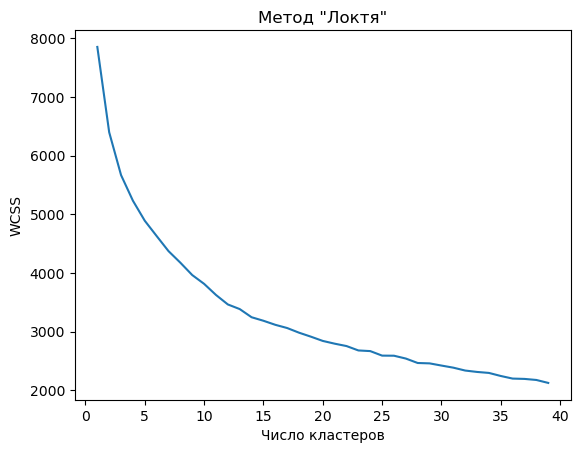

In [6]:
import warnings
warnings.filterwarnings('ignore')
wcss = []
t_max = 40

# Применим k-средних для k от 1 до t_max
for i in range(1, t_max):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaler)
    wcss.append(kmeans.inertia_)
# Визуализация результатов

plt.plot(range(1, t_max), wcss)
plt.title('Метод "Локтя"')
plt.xlabel('Число кластеров')
plt.ylabel('WCSS')
plt.show()

### Исходя из графика можно выбрать число лкастеров 20

## Рассчитаем K-means

In [7]:
K=20

In [8]:
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaler) 

In [9]:
df_kmean = df_scaled.copy()
df_kmean["Cluster"] = clusters  # добавляем колонку кластеров

In [10]:
df_kmean

PassengerId    Pclass      Name       Sex       Age     SibSp     Parch  \
0      -1.728532  0.911232 -1.192187  0.759051 -0.530377  0.524570 -0.505895   
1      -1.724670 -1.476364 -0.881388 -1.317434  0.571831  0.524570 -0.505895   
2      -1.720808  0.911232 -0.263580 -1.317434 -0.254825 -0.551703 -0.505895   
3      -1.716946 -1.476364 -0.570589 -1.317434  0.365167  0.524570 -0.505895   
4      -1.713084  0.911232 -1.544678  0.759051  0.365167 -0.551703 -0.505895   
..           ...       ...       ...       ...       ...       ...       ...   
709     1.689274  0.911232  0.990986 -1.317434  0.640719 -0.551703  5.357890   
710     1.693136 -0.282566  0.475515  0.759051 -0.185937 -0.551703 -0.505895   
711     1.696998 -1.476364 -0.453092 -1.317434 -0.737041 -0.551703 -0.505895   
712     1.704722 -1.476364 -1.294523  0.759051 -0.254825 -0.551703 -0.505895   
713     1.708584  0.911232 -0.767681  0.759051  0.158503 -0.551703 -0.505895   

       Ticket      Fare     Cabin  Embarked  Cluster  
0    0.922675 -0.518978  0.485988  0.512924       10  
1    1.281724  0.691897 -1.272974 -2.048108       12  
2    1.640772 -0.506214  0.485988  0.512924       17  
3   -1.408681  0.348049 -1.965898  0.512924        4  
4    0.671833 -0.503850  0.485988  0.512924       10  
..        ...       ...       ...       ...      ...  
709  0.711181 -0.105320  0.485988 -0.767592        9  
710 -1.152920 -0.410245  0.485988  0.512924        7  
711 -1.580828 -0.088774 -2.632171  0.512924        4  
712 -1.610338 -0.088774 -1.832643 -2.048108       18  
713  0.642322 -0.509523  0.485988 -0.767592        3  

[714 rows x 12 columns]

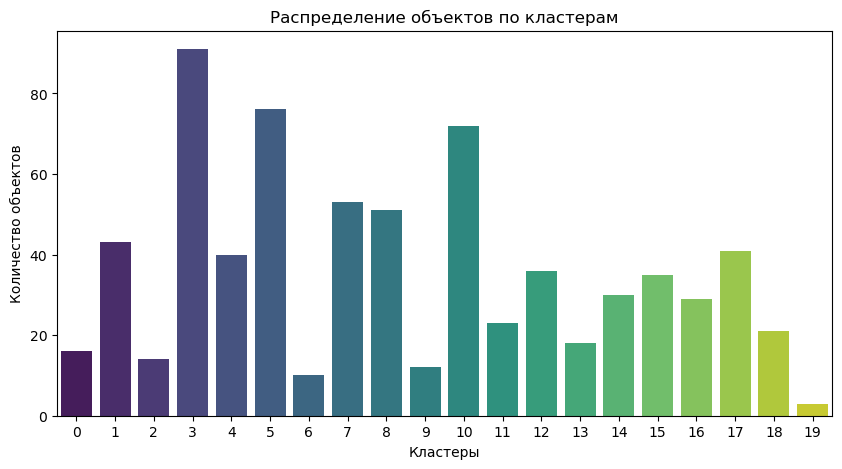

In [11]:
unique, counts = np.unique(clusters, return_counts=True)

plt.figure(figsize=(10, 5))
sns.barplot(x=unique, y=counts, palette="viridis")

plt.xlabel("Кластеры")
plt.ylabel("Количество объектов")
plt.title("Распределение объектов по кластерам")
plt.xticks(unique)
plt.show()

### Получили очень большео кол-во кластеров. И часть класторов очень маленькие. Попробуем подобрать кол-во кластеров методом сиулэтов.

## Метод силуэтов

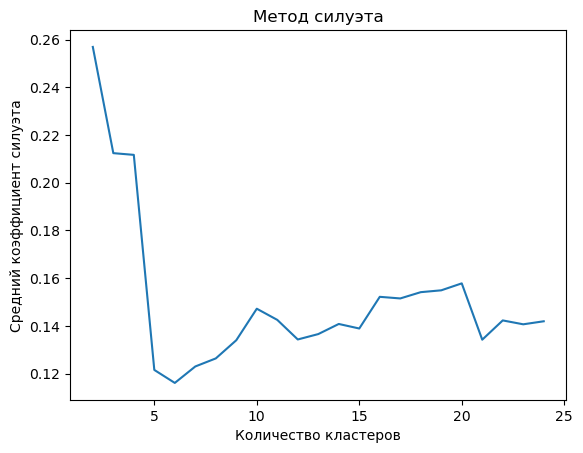

In [12]:
sil_scores = []
for k in range(2, 25):  # Пробуем значения от 2 до 19 кластеров
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaler)
    sil_scores.append(silhouette_score(X_scaler, kmeans.labels_))

# Строим график
plt.plot(range(2, 25), sil_scores)  # Диапазон должен быть от 2 до 19
plt.title('Метод силуэта')
plt.xlabel('Количество кластеров')
plt.ylabel('Средний коэффициент силуэта')
plt.show()

## Перед использованием иерархической кластеризации проверим выборку на адекватность размера

In [13]:
print(f"Titanic dataset: {X_scaler.shape}")
pca = PCA(n_components=2)  
X_titanic_pca = pca.fit_transform(X_scaler)
print(f"X_titanic_pca: {X_titanic_pca}")
print(f'X_titanic_pca.shape {X_titanic_pca.shape}')

Titanic dataset: (714, 11)
X_titanic_pca: [[ 1.66451844  0.30050514  0.79625351 -0.69196657 -2.01287888]
 [-2.35126569  0.64811369  2.36410071 -0.28587086 -1.25414411]
 [ 1.38779598  0.20847495  1.46430868  0.6575002  -0.90378127]
 ...
 [-2.45191814 -0.25062845 -2.11413562 -0.50128728  0.98287664]
 [-2.51912516 -0.91742576 -0.80696833 -2.182115    0.6493493 ]
 [ 0.93210362 -0.94471779  0.33041273 -1.76047997  1.29958342]]
X_titanic_pca.shape (714, 5)


In [14]:
# Функция для теста времени на подвыборке
def test_hierarchical(X, sample_size=1000):
    if len(X) > sample_size:
        X_sample = X.sample(sample_size, random_state=42)  # Берем подвыборку
    else:
        X_sample = X

    start_time = time.time()
    model = AgglomerativeClustering(n_clusters=5).fit(X_sample)
    elapsed_time = time.time() - start_time
    print(f"Время выполнения для {len(X_sample)} точек: {elapsed_time:.3f} сек")

In [15]:
# Для простых номрмированных данных
test_hierarchical(X_scaler)

Время выполнения для 714 точек: 0.012 сек


In [16]:
#"Для объединенных данных: 
test_hierarchical(X_titanic_pca)

Время выполнения для 714 точек: 0.014 сек


## Сделаем DBSCAN для сравнения данных

### График расстояний до ближайших соседей для выбора eps:

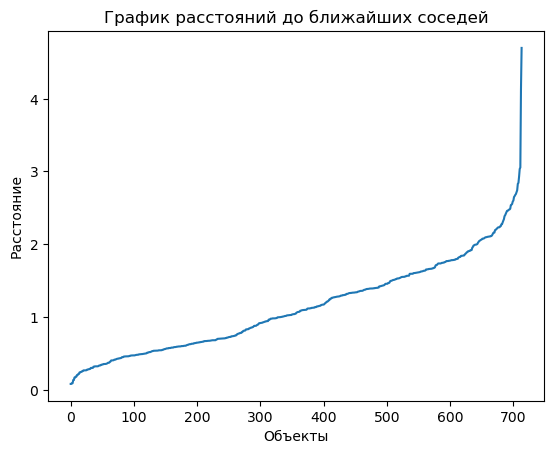

In [17]:
# Найдем расстояния до ближайших соседей
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(X_scaler)
distances, indices = neighbors_fit.kneighbors(X_scaler)

# Сортируем расстояния по возрастанию
distances = np.sort(distances[:, 1], axis=0)

# Строим график
plt.plot(distances)
plt.title('График расстояний до ближайших соседей')
plt.xlabel('Объекты')
plt.ylabel('Расстояние')
plt.show()

### Исходя из графика подходящее eps - 2.5

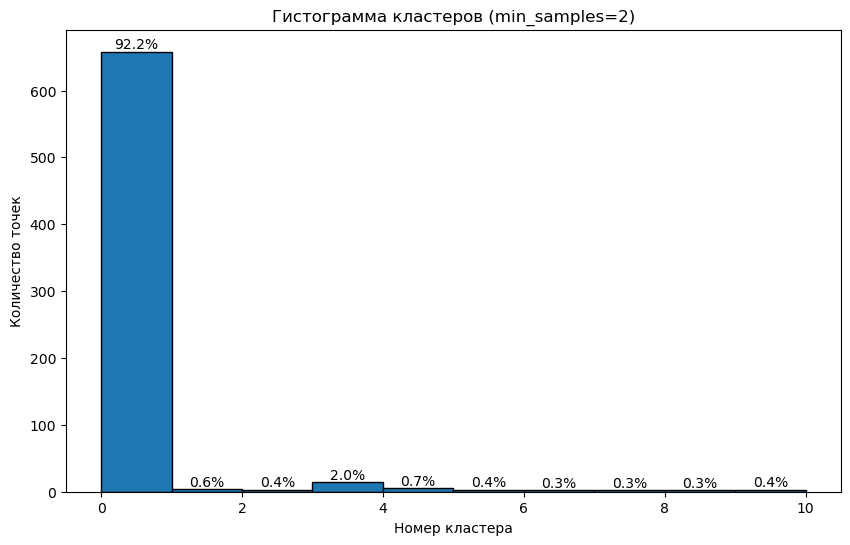

min_samples = 2: Количество кластеров = 10, Точки, классифицированные как шум: 18


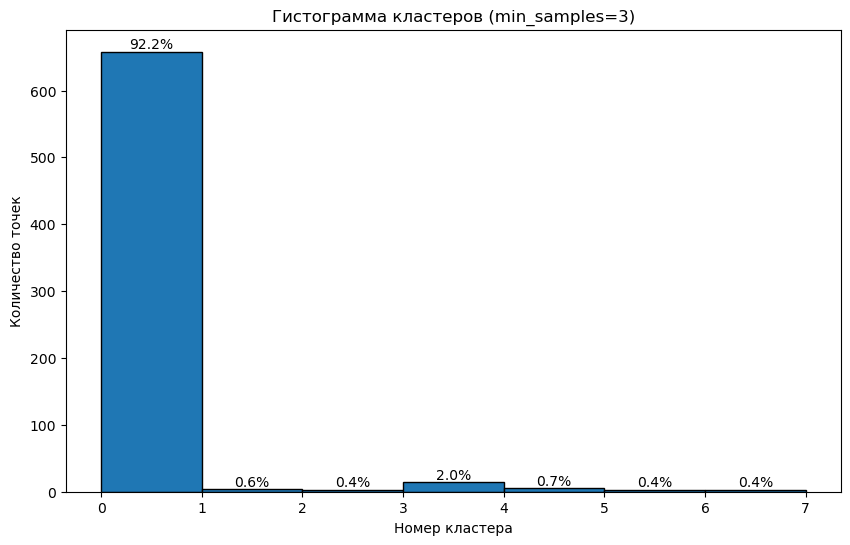

min_samples = 3: Количество кластеров = 7, Точки, классифицированные как шум: 24


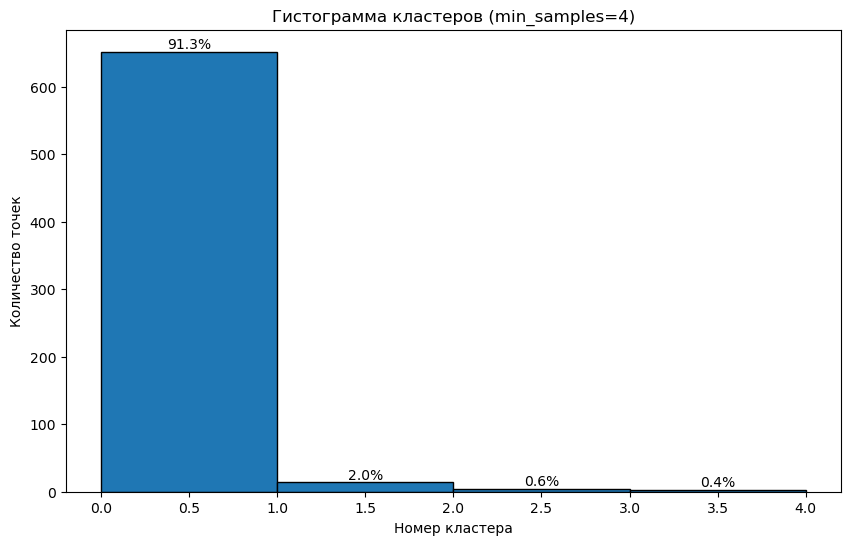

min_samples = 4: Количество кластеров = 4, Точки, классифицированные как шум: 41


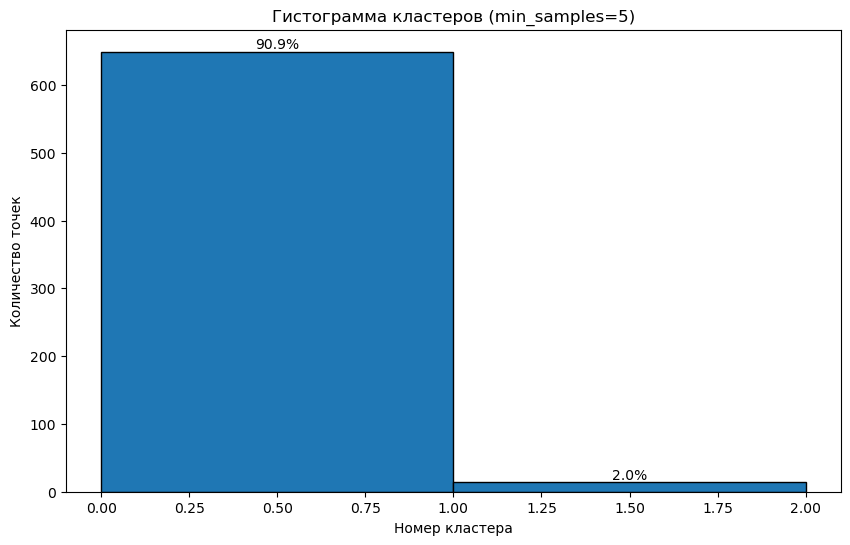

min_samples = 5: Количество кластеров = 2, Точки, классифицированные как шум: 51


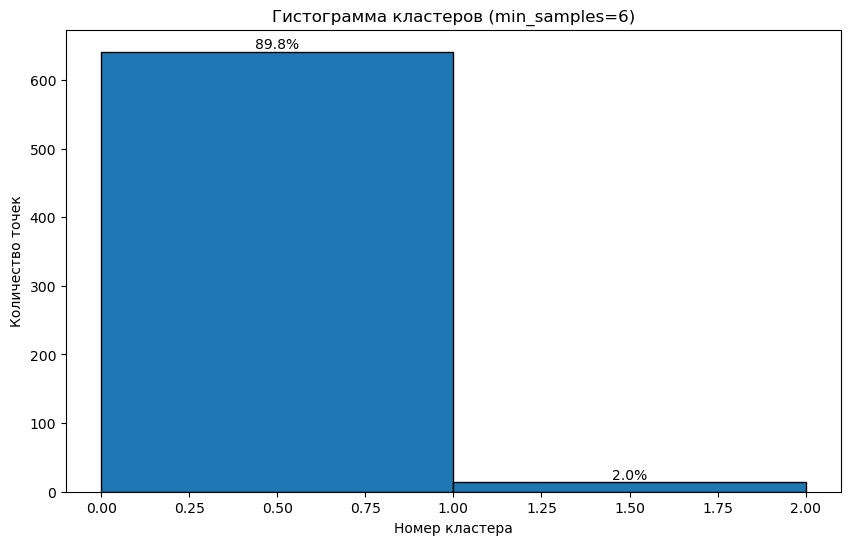

min_samples = 6: Количество кластеров = 2, Точки, классифицированные как шум: 59


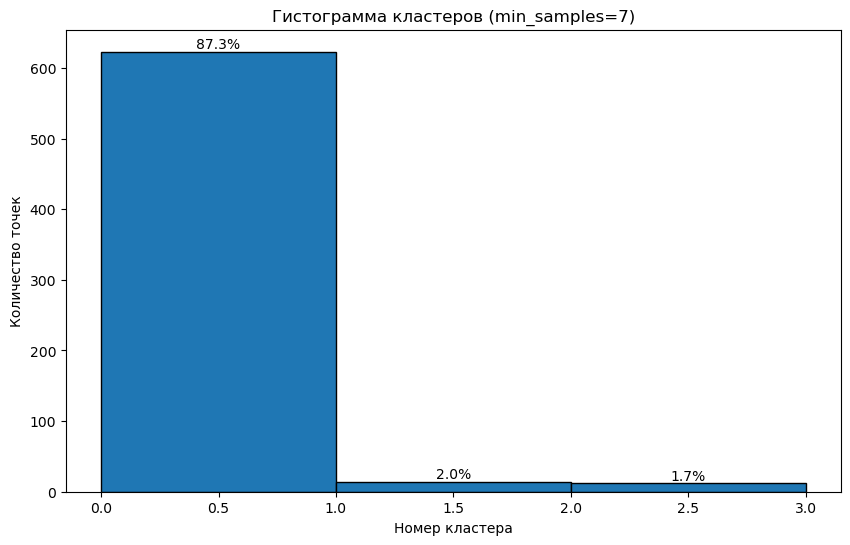

min_samples = 7: Количество кластеров = 3, Точки, классифицированные как шум: 65


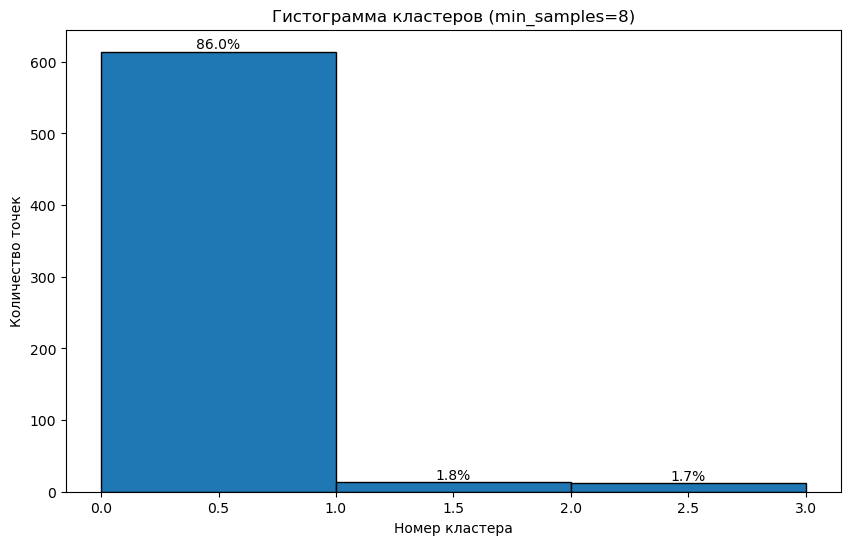

min_samples = 8: Количество кластеров = 3, Точки, классифицированные как шум: 75


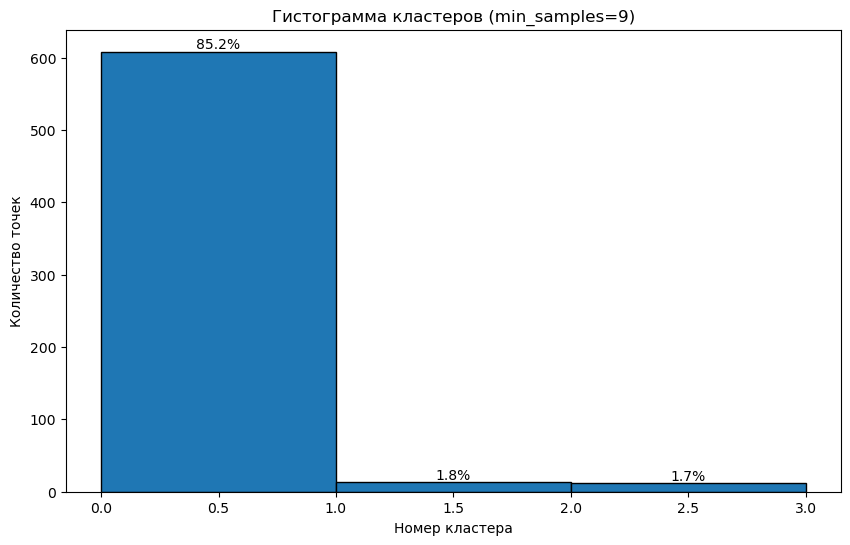

min_samples = 9: Количество кластеров = 3, Точки, классифицированные как шум: 81


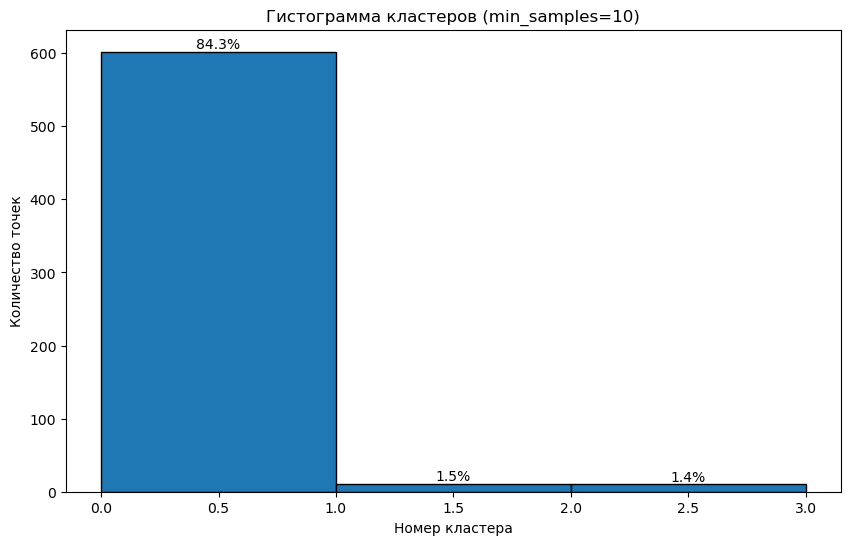

min_samples = 10: Количество кластеров = 3, Точки, классифицированные как шум: 91


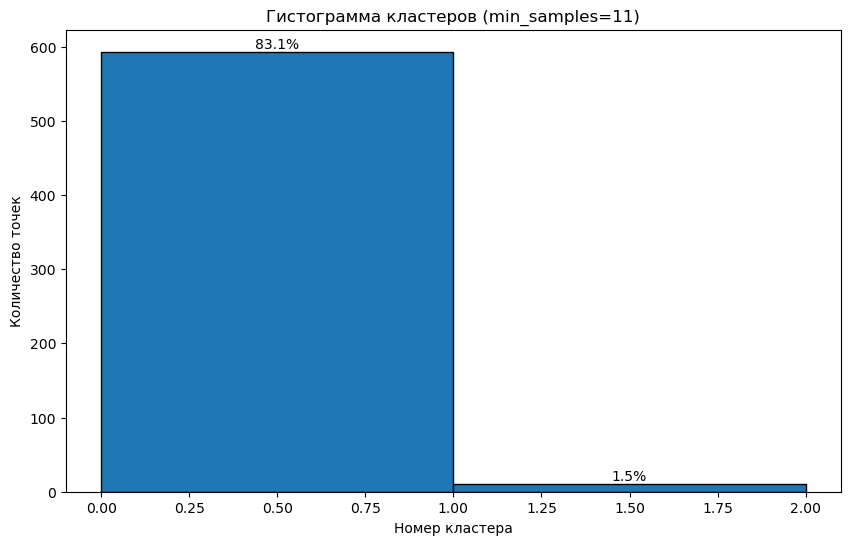

min_samples = 11: Количество кластеров = 2, Точки, классифицированные как шум: 110


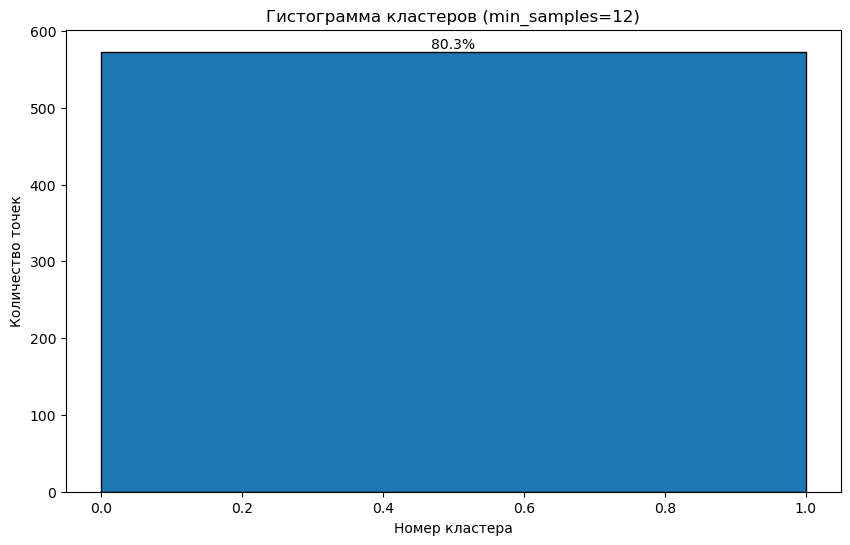

min_samples = 12: Количество кластеров = 1, Точки, классифицированные как шум: 141
min_samples = 2: 10 кластеров, шумных точек: 18
min_samples = 3: 7 кластеров, шумных точек: 24
min_samples = 4: 4 кластеров, шумных точек: 41
min_samples = 5: 2 кластеров, шумных точек: 51
min_samples = 6: 2 кластеров, шумных точек: 59
min_samples = 7: 3 кластеров, шумных точек: 65
min_samples = 8: 3 кластеров, шумных точек: 75
min_samples = 9: 3 кластеров, шумных точек: 81
min_samples = 10: 3 кластеров, шумных точек: 91
min_samples = 11: 2 кластеров, шумных точек: 110
min_samples = 12: 1 кластеров, шумных точек: 141


In [18]:
min_samples_values = range(2, 13)  # Пробуем значения от 2 до 10 для min_samples
eps = 2.5

# Создаем пустой список для хранения информации о кластерах
cluster_counts = []
eps = 2.5

cluster_counts = []

# Проходим по всем значениям min_samples
for min_samples in min_samples_values:
    # Инициализируем DBSCAN с текущими значениями
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    
    # Применяем алгоритм кластеризации
    clusters = dbscan.fit_predict(X_scaler)  # X_scaler - ваши нормализованные данные
    
    # Получаем количество кластеров (кроме шума)
    unique_clusters = set(clusters)
    num_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)  # Минус 1, если есть шум
    
    # Добавляем информацию в список
    cluster_counts.append((min_samples, num_clusters, clusters))
    
    # Подсчитываем количество точек в каждом кластере
    cluster_counts_dict = Counter(clusters)
    total_points = len(clusters)
    
    # Строим гистограмму для текущих кластеров
    plt.figure(figsize=(10, 6))
    n, bins, patches = plt.hist(clusters[clusters != -1], bins=range(num_clusters + 1), edgecolor='black')  # Игнорируем шум
    plt.title(f'Гистограмма кластеров (min_samples={min_samples})')
    plt.xlabel('Номер кластера')
    plt.ylabel('Количество точек')
    
    # Добавляем проценты в каждый столбец
    for i in range(num_clusters):
        percentage = (n[i] / total_points) * 100
        plt.text(bins[i] + 0.5, n[i] + 0.2, f'{percentage:.1f}%', ha='center', va='bottom', fontsize=10)
    
    # Показываем график
    plt.show()
    
    print(f"min_samples = {min_samples}: Количество кластеров = {num_clusters}, "
          f"Точки, классифицированные как шум: {sum(clusters == -1)}")

# Печатаем количество кластеров для каждого min_samples
for min_samples, num_clusters, clusters in cluster_counts:
    print(f"min_samples = {min_samples}: {num_clusters} кластеров, "
          f"шумных точек: {sum(clusters == -1)}")

### Вывод: Во всех выводах, для всех min_samples - большая часть данных в одном первом кластере. и даже при увеличении данные попадали не в другие кластеры а в шум. Следовательно имеет смысл использовать min_samples = 11 т.е вэтом случае (за счет более жестких условий) у нас более стабильная модель и мы всеже иимеем два кластера при дальньйшем увеличении кластер остается только 1 что теряет смысл кластеризации (кроме поиска аномалий, наверное)

## Сделаем иерархическую кластеризацию

In [19]:
# Вычисляем матрицу попарных расстояний (т.к категориальных данных многовато)
X_gower = gower_matrix(df_scaled)

In [20]:
# Преобразуем X_gower в конденсированную матрицу
condensed_matrix = squareform(X_gower)

In [21]:
# Иерархическая кластеризация
Z = linkage(condensed_matrix, method="average")

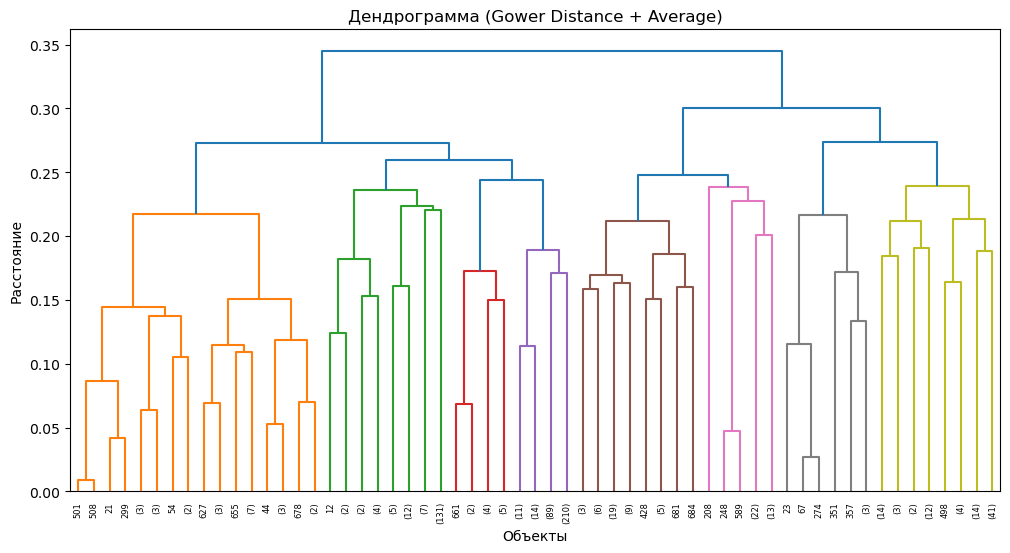

In [22]:
# Визуализация дендрограммы
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode="level", p=5)
plt.title("Дендрограмма (Gower Distance + Average)")
plt.xlabel("Объекты")
plt.ylabel("Расстояние")
plt.show()

In [23]:
# Попробуем отсевение на уровне 0,1-
max_d = 0.25  # Порог отсечения
clusters_1 = fcluster(Z, max_d, criterion='distance')

# Выводим количество кластеров
print(f"Количество кластеров: {len(set(clusters_1))}")

Количество кластеров: 6


In [24]:
# Попробуем отсевение на уровне 0,2
max_d = 0.2  # Порог отсечения
clusters_2 = fcluster(Z, max_d, criterion='distance')

# Выводим количество кластеров
print(f"Количество кластеров: {len(set(clusters_2))}")

Количество кластеров: 20


In [25]:
# Попробуем отсевение на уровне 0,3
max_d = 0.3  # Порог отсечения
clusters_3 = fcluster(Z, max_d, criterion='distance')

# Выводим количество кластеров
print(f"Количество кластеров: {len(set(clusters_3))}")

Количество кластеров: 3


In [26]:
max_d = 0.2

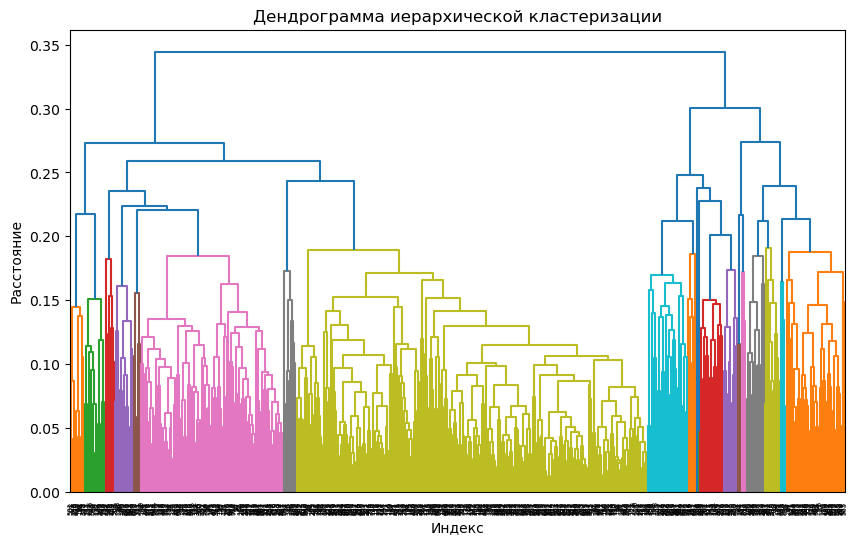

In [27]:
plt.figure(figsize=(10, 6))
dendrogram(Z, color_threshold=max_d)  # порог для выделения кластеров
plt.title("Дендрограмма иерархической кластеризации")
plt.xlabel("Индекс")
plt.ylabel("Расстояние")
plt.show()

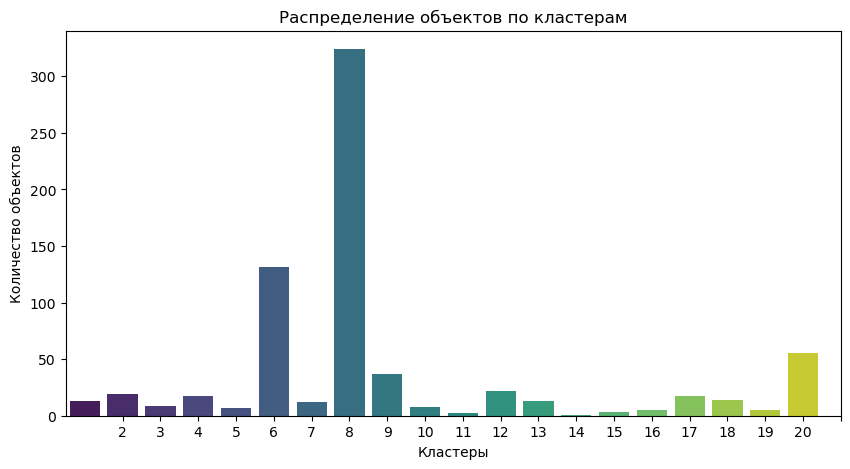

In [28]:
unique, counts = np.unique(clusters_2, return_counts=True)

plt.figure(figsize=(10, 5))
sns.barplot(x=unique, y=counts, palette="viridis")

plt.xlabel("Кластеры")
plt.ylabel("Количество объектов")
plt.title("Распределение объектов по кластерам")
plt.xticks(unique)
plt.show()

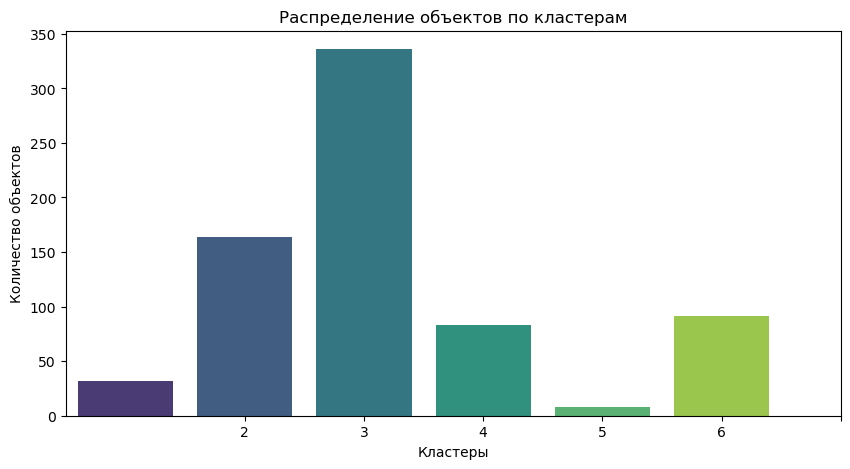

In [29]:
unique, counts = np.unique(clusters_1, return_counts=True)

plt.figure(figsize=(10, 5))
sns.barplot(x=unique, y=counts, palette="viridis")

plt.xlabel("Кластеры")
plt.ylabel("Количество объектов")
plt.title("Распределение объектов по кластерам")
plt.xticks(unique)
plt.show()

In [30]:
# Преобразуем результат linkage в DataFrame для удобства анализа
Z_df = pd.DataFrame(Z, columns=["Cluster 1", "Cluster 2", "Distance", "Sample Count"])

Z_df

Cluster 1  Cluster 2  Distance  Sample Count
0        429.0      430.0  0.002489           2.0
1        533.0      545.0  0.003770           2.0
2        313.0      317.0  0.003879           2.0
3        511.0      544.0  0.006157           2.0
4         68.0       69.0  0.006970           2.0
..         ...        ...       ...           ...
708     1417.0     1420.0  0.259233         500.0
709     1413.0     1422.0  0.272854         532.0
710     1412.0     1419.0  0.273655          99.0
711     1421.0     1424.0  0.300455         182.0
712     1423.0     1425.0  0.344603         714.0

[713 rows x 4 columns]

In [31]:
pca = PCA(n_components=5)
X_titanic_pca = pca.fit_transform(X_scaler)

In [32]:
max_d = 0.3  # Порог отсечения
clusters_4 = fcluster(Z, max_d, criterion='distance')

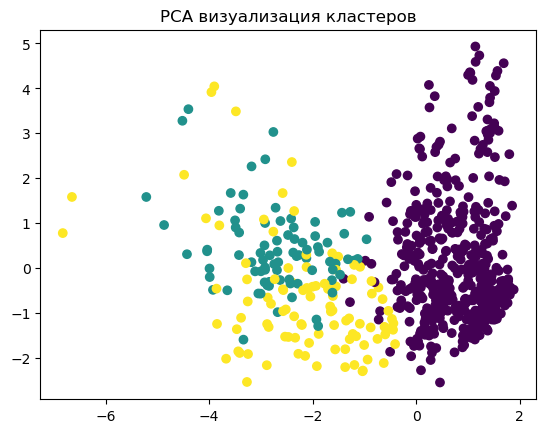

In [33]:
# Визуализируем данные после PCA
plt.scatter(X_titanic_pca[:, 0], X_titanic_pca[:, 1], c=clusters_3)
plt.title('PCA визуализация кластеров')
plt.show()

In [34]:
pca = PCA(n_components=5)
X_titanic_pca2 = pca.fit_transform(X_scaler)

In [35]:
max_d = 0.25  # Порог отсечения
clusters_5 = fcluster(Z, max_d, criterion='distance')

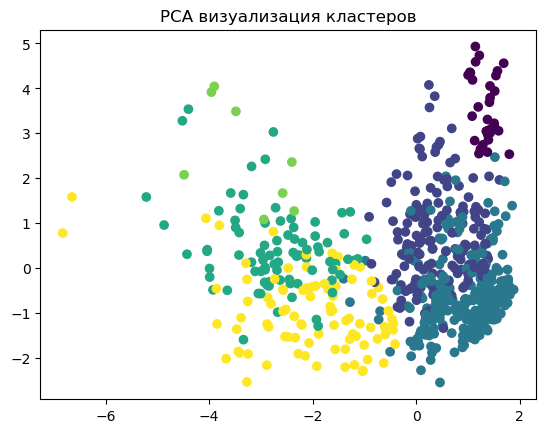

In [36]:
# Визуализируем данные после PCA
plt.scatter(X_titanic_pca2[:, 0], X_titanic_pca2[:, 1], c=clusters_5)
plt.title('PCA визуализация кластеров')
plt.show()

### Разбивки при  max_d = 0.25 и max_d = 0.3  имеют вполне четкое и приемлимое отображение. Попробуем связать наши кластеры с данными.

## Попробуем для max_d = 0.3

In [37]:
df_clusters = pd.DataFrame(X_scaler, columns=X.columns)  # Используем X.columns для имен столбцов
df_clusters['Cluster'] = clusters_3

for cluster_num in np.unique(clusters_3):
    cluster_data = df_clusters[df_clusters['Cluster'] == cluster_num]
    
    print(f"Кластер {cluster_num}:\n")
    print(cluster_data.drop(columns=['Cluster']))  # Выводим все фичи для объектов в кластере
    
    # Сначала создаем список для хранения модальных значений
    mode_values = {}
    
    # Для каждого признака находим самое частое значение и среднее
    for column in cluster_data.drop(columns=['Cluster']).columns:
        # Находим самое частое значение (модальное) и его процентное соотношение
        mode_value = cluster_data[column].mode()[0]  # Самое частое значение
        mode_percent = (cluster_data[column].value_counts(normalize=True).max()) * 100  # Процентное соотношение
        
        # Среднее значение признака
        mean_value = cluster_data[column].mean()
        
        # Сохраняем модальные и средние значения в словарь
        mode_values[column] = (mode_value, mean_value)
    
    # Выводим модальные значения (самое частое) и средние значения
    print(f"\nСамые частые значения и средние для Кластера {cluster_num}:")
    for column, (mode_value, mean_value) in mode_values.items():
        print(f"  {column}:")
        print(f"    Самое частое значение: {mode_value} ({(cluster_data[column].value_counts(normalize=True).max()) * 100:.2f}%)")
        print(f"    Среднее значение: {mean_value:.2f}")
    
    print("\n" + "="*40 + "\n")

Кластер 1:

     PassengerId    Pclass      Name       Sex       Age     SibSp     Parch  \
0      -1.728532  0.911232 -1.192187  0.759051 -0.530377  0.524570 -0.505895   
2      -1.720808  0.911232 -0.263580 -1.317434 -0.254825 -0.551703 -0.505895   
4      -1.713084  0.911232 -1.544678  0.759051  0.365167 -0.551703 -0.505895   
6      -1.701499  0.911232  0.763572  0.759051 -1.908136  2.677117  0.666862   
7      -1.697637  0.911232 -0.039957 -1.317434 -0.185937 -0.551703  1.839619   
..           ...       ...       ...       ...       ...       ...       ...   
707     1.681551 -0.282566 -1.370327  0.759051 -0.117049 -0.551703 -0.505895   
708     1.685413  0.911232  1.404121  0.759051 -0.323713 -0.551703 -0.505895   
709     1.689274  0.911232  0.990986 -1.317434  0.640719 -0.551703  5.357890   
710     1.693136 -0.282566  0.475515  0.759051 -0.185937 -0.551703 -0.505895   
713     1.708584  0.911232 -0.767681  0.759051  0.158503 -0.551703 -0.505895   

       Ticket      Fare    

In [38]:
# Обратная нормализация
X_original = scaler.inverse_transform(X_scaler)

# Преобразуем обратно в DataFrame с оригинальными значениями
df_original = pd.DataFrame(X_original, columns=X.columns)

# Раскодируем категориальные данные с использованием сохраненных LabelEncoder
df_original['Name'] = label_encoders['Name'].inverse_transform(df_original['Name'].astype(int))
df_original['Sex'] = label_encoders['Sex'].inverse_transform(df_original['Sex'].astype(int))
df_original['Ticket'] = label_encoders['Ticket'].inverse_transform(df_original['Ticket'].astype(int))

In [39]:
# Теперь можно анализировать категориальные признаки, например, Name, Sex, Ticket
df_original['Cluster'] = clusters_3

# Теперь можем анализировать кластеры
for cluster_num in np.unique(clusters_3):
    cluster_data = df_original[df_original['Cluster'] == cluster_num]
    print(f"Кластер {cluster_num}:")

    # Для категориальных признаков выводим наиболее частое значение
    for column in ['Name', 'Sex', 'Ticket']:
        mode_value = cluster_data[column].mode()[0]
        mode_percent = (cluster_data[column].value_counts(normalize=True).max()) * 100
        
        print(f"  {column}: Самое частое значение: {mode_value} ({mode_percent:.2f}%)")
    
    # Для числовых признаков выводим средние значения
    for column in cluster_data.drop(columns=['Cluster', 'Name', 'Sex', 'Ticket']).columns:
        mean_value = cluster_data[column].mean()
        print(f"  {column}: Среднее значение: {mean_value:.2f}")
    
    print("\n")

Кластер 1:
  Name: Самое частое значение: Andersson, Miss. Ellis Anna Maria (0.38%)
  Sex: Самое частое значение: male (66.92%)
  Ticket: Самое частое значение: 347082 (1.32%)
  PassengerId: Среднее значение: 440.95
  Pclass: Среднее значение: 2.66
  Age: Среднее значение: 26.76
  SibSp: Среднее значение: 0.53
  Parch: Среднее значение: 0.44
  Fare: Среднее значение: 16.39
  Cabin: Среднее значение: 146.17
  Embarked: Среднее значение: 1.73


Кластер 2:
  Name: Самое частое значение: Allen, Miss. Elisabeth Walton (1.20%)
  Sex: Самое частое значение: female (100.00%)
  Ticket: Самое частое значение: 110152 (3.61%)
  PassengerId: Среднее значение: 484.61
  Pclass: Среднее значение: 1.00
  Age: Среднее значение: 34.88
  SibSp: Среднее значение: 0.48
  Parch: Среднее значение: 0.46
  Fare: Среднее значение: 104.21
  Cabin: Среднее значение: 77.05
  Embarked: Среднее значение: 1.10


Кластер 3:
  Name: Самое частое значение: Allison, Master. Hudson Trevor (1.01%)
  Sex: Самое частое значен

## Попробуем для max_d = 0.25

In [40]:
df_clusters = pd.DataFrame(X_scaler, columns=X.columns)  # Используем X.columns для имен столбцов
df_clusters['Cluster'] = clusters_1

for cluster_num in np.unique(clusters_1):
    cluster_data = df_clusters[df_clusters['Cluster'] == cluster_num]
    
    print(f"Кластер {cluster_num}:\n")
    print(cluster_data.drop(columns=['Cluster']))  # Выводим все фичи для объектов в кластере
    
    # Сначала создаем список для хранения модальных значений
    mode_values = {}
    
    # Для каждого признака находим самое частое значение и среднее
    for column in cluster_data.drop(columns=['Cluster']).columns:
        # Находим самое частое значение (модальное) и его процентное соотношение
        mode_value = cluster_data[column].mode()[0]  # Самое частое значение
        mode_percent = (cluster_data[column].value_counts(normalize=True).max()) * 100  # Процентное соотношение
        
        # Среднее значение признака
        mean_value = cluster_data[column].mean()
        
        # Сохраняем модальные и средние значения в словарь
        mode_values[column] = (mode_value, mean_value)
    
    # Выводим модальные значения (самое частое) и средние значения
    print(f"\nСамые частые значения и средние для Кластера {cluster_num}:")
    for column, (mode_value, mean_value) in mode_values.items():
        print(f"  {column}:")
        print(f"    Самое частое значение: {mode_value} ({(cluster_data[column].value_counts(normalize=True).max()) * 100:.2f}%)")
        print(f"    Среднее значение: {mean_value:.2f}")
    
    print("\n" + "="*40 + "\n")

Кластер 1:

     PassengerId    Pclass      Name       Sex       Age     SibSp     Parch  \
6      -1.701499  0.911232  0.763572  0.759051 -1.908136  2.677117  0.666862   
15     -1.666741  0.911232  0.983405  0.759051 -1.908136  3.753390  0.666862   
21     -1.635846  0.911232  0.771153 -1.317434 -1.494808  2.677117  0.666862   
36     -1.535436  0.911232  0.782523  0.759051 -1.563696  3.753390  0.666862   
44     -1.500678  0.911232 -0.468253  0.759051 -1.288144  4.829663  1.839619   
48     -1.485231  0.911232  1.260092  0.759051 -1.770360  2.677117  1.839619   
51     -1.465921  0.911232 -1.506776 -1.317434 -0.874817  3.753390  1.839619   
54     -1.454335  0.911232 -0.464462 -1.317434 -0.943705  4.829663  1.839619   
94     -1.268963  0.911232 -1.510566 -1.317434 -1.908136  3.753390  1.839619   
118    -1.160829  0.911232 -0.638813 -1.317434 -1.425920  1.600843  1.839619   
132    -1.095176  0.911232  0.778733  0.759051 -1.977024  3.753390  0.666862   
137    -1.068142  0.911232  

In [47]:
# Преобразуем обратно в DataFrame с оригинальными значениями
df_original2 = pd.DataFrame(X_original, columns=X.columns)
# Теперь можно анализировать категориальные признаки, например, Name, Sex, Ticket
df_original2['Cluster'] = clusters_1


In [48]:
df_original2

PassengerId  Pclass   Name  Sex   Age  SibSp         Parch  Ticket  \
0            1.0     3.0  108.0  1.0  22.0    1.0 -5.551115e-17   523.0   
1            2.0     1.0  190.0  0.0  38.0    1.0 -5.551115e-17   596.0   
2            3.0     3.0  353.0  0.0  26.0    0.0 -5.551115e-17   669.0   
3            4.0     1.0  272.0  0.0  35.0    1.0 -5.551115e-17    49.0   
4            5.0     3.0   15.0  1.0  35.0    0.0 -5.551115e-17   472.0   
..           ...     ...    ...  ...   ...    ...           ...     ...   
709        886.0     3.0  684.0  0.0  39.0    0.0  5.000000e+00   480.0   
710        887.0     2.0  548.0  1.0  27.0    0.0 -5.551115e-17   101.0   
711        888.0     1.0  303.0  0.0  19.0    0.0 -5.551115e-17    14.0   
712        890.0     1.0   81.0  1.0  26.0    0.0 -5.551115e-17     8.0   
713        891.0     3.0  220.0  1.0  32.0    0.0 -5.551115e-17   466.0   

        Fare  Cabin  Embarked  Cluster  
0     7.2500  147.0       2.0        3  
1    71.2833   81.0       0.0        4  
2     7.9250  147.0       2.0        2  
3    53.1000   55.0       2.0        4  
4     8.0500  147.0       2.0        3  
..       ...    ...       ...      ...  
709  29.1250  147.0       1.0        2  
710  13.0000  147.0       2.0        3  
711  30.0000   30.0       2.0        4  
712  30.0000   60.0       0.0        6  
713   7.7500  147.0       1.0        3  

[714 rows x 12 columns]

In [49]:
# Теперь можем анализировать кластеры
for cluster_num in np.unique(clusters_1):
    cluster_data = df_original2[df_original2['Cluster'] == cluster_num]
    print(f"Кластер {cluster_num}:")

    # Для категориальных признаков выводим наиболее частое значение
    for column in ['Name', 'Sex', 'Ticket']:
        mode_value = cluster_data[column].mode()[0]
        mode_percent = (cluster_data[column].value_counts(normalize=True).max()) * 100
        
        print(f"  {column}: Самое частое значение: {mode_value} ({mode_percent:.2f}%)")
    
    # Для числовых признаков выводим средние значения
    for column in cluster_data.drop(columns=['Cluster', 'Name', 'Sex', 'Ticket']).columns:
        mean_value = cluster_data[column].mean()
        print(f"  {column}: Среднее значение: {mean_value:.2f}")
    
    print("\n")

Кластер 1:
  Name: Самое частое значение: 22.0 (3.12%)
  Sex: Самое частое значение: 1.0 (59.38%)
  Ticket: Самое частое значение: 249.0 (15.62%)
  PassengerId: Среднее значение: 365.88
  Pclass: Среднее значение: 3.00
  Age: Среднее значение: 7.69
  SibSp: Среднее значение: 3.81
  Parch: Среднее значение: 1.62
  Fare: Среднее значение: 32.86
  Cabin: Среднее значение: 147.00
  Embarked: Среднее значение: 1.88


Кластер 2:
  Name: Самое частое значение: 2.0 (0.61%)
  Sex: Самое частое значение: 0.0 (99.39%)
  Ticket: Самое частое значение: 194.0 (2.44%)
  PassengerId: Среднее значение: 424.36
  Pclass: Среднее значение: 2.55
  Age: Среднее значение: 26.01
  SibSp: Среднее значение: 0.47
  Parch: Среднее значение: 0.76
  Fare: Среднее значение: 17.66
  Cabin: Среднее значение: 145.52
  Embarked: Среднее значение: 1.65


Кластер 3:
  Name: Самое частое значение: 0.0 (0.30%)
  Sex: Самое частое значение: 1.0 (100.00%)
  Ticket: Самое частое значение: 621.0 (1.49%)
  PassengerId: Среднее з

### Вывод:
- Для max_d = 0.25 и 6 кластерам
Кластер 1 ():
Средний возраст 7.69 лет.
Возможно, в этом кластере сосредоточены дети или пассажиры младшего возраста.
Преобладание женщин (Sex = 1.0, 59.38%) также может указывать на группы, в которых было много матерей с детьми.
Среднее значение Fare (32.86) может подразумевать, что пассажиры этого кластера были средним или низким социальным статусом.

Кластер 2:
Средний возраст 26.01 лет.
Это может быть кластер людей, которые были молоды и не в значительном количестве путешествовали в семейном составе.
Низкое количество семейных пассажиров (SibSp = 0.47, Parch = 0.76) подтверждает, что это могут быть одиночные путешественники.

Кластер 3:
Средний возраст 28.94 лет.
Здесь больше одиночных пассажиров, что можно подтвердить низким значением SibSp и Parch.
Среднее значение Fare 14.20 может свидетельствовать о более низком классе обслуживания.

Кластер 4 :
Средний возраст 34.88 лет.
Высокая стоимость билетов (104.21) и Pclass = 1 указывает на пассажиров высокого социального статуса.
Вероятно, это пассажиры, путешествующие в первом классе, с большим количеством багажа или более высокими доходами.
Преобладание мужчин (Sex = 0.0, 100%) и низкое количество людей в семейных составах (SibSp и Parch) может указывать на бизнесменов или деловых людей, путешествующих без семей.


Кластер 5:
Средний возраст 22.74 лет.
Высокая стоимость билетов (190.68) и Pclass = 1 могут подразумевать пассажиров, которые приобрели дорогие билеты, возможно, для поездок в элитных классах.
Преобладание женщин (Sex = 1.0, 75%) может свидетельствовать о том, что это были высокостатусные дамы или представители семей.

Кластер 6:
Средний возраст 42.79 лет.
Очень высокая стоимость билетов (64.61) и более старший возраст (42.79) указывают на тех, кто, вероятно, был в возрасте, когда могут позволить себе более дорогие путешествия.
Сильно выраженная мужская преобладание (Sex = 1.0) может также указывать на бизнесменов или людей с более высокими доходами.

- Для max_d = 0.3 и 3 кластерам
Кластер 1 :

Ticket = 347082 (1.32%) может означать популярные или стандартные билеты для путешествий в межсезонье, в отличие от более дорогих билетов.

Кластер 2 :
Ticket = 110152 (3.61%) может указывать на другие типы билетов, возможно, премиум-класса или для более важных пассажиров.

### Итоговые выводы по датасету: 

Судя по результатам, иерархическая кластеризация с максимальным расстоянием (max_d = 0.25) и 6 кластерами дает более интерпретируемые результаты для данного датасета. Это подтверждается:

- Ясностью интерпретации кластеров: Кластеры, полученные при max_d = 0.25, представляют собой более однородные группы с осмысленными характеристиками по признакам, таким как возраст, пол, класс и стоимость билета. Это позволяет сделать более четкие выводы о типах пассажиров, что не удалось сдеолать при использовании методов, как K-means или DBSCAN.

Меньше шумовых данных: В случае с иерархической кластеризацией, использование среза позволило получить хорошо инетрпретируемое кол-во кластеров. В случае с K-means и с DBSCAN мы получили довольно большое кол-во шумовых кластеров (с несравинмо меньшим кол-во данных)


## Попробуем использовать PCA и пересчитать данные

In [150]:
print(f"Titanic dataset: {X_scaler.shape}")
pca = PCA(n_components=5)  
X_titanic_pca = pca.fit_transform(X_scaler)


Titanic dataset: (714, 11)


In [151]:
# Проверяем накопленную дисперсию
cumulative_variance = pca.explained_variance_ratio_.cumsum()

print(cumulative_variance)

# Ищем количество компонент для 95% объясненной дисперсии
n_components_for_95 = (cumulative_variance >= 0.95).argmax() + 1
print(f"Number of components for 95% variance: {n_components_for_95}")


[0.23382211 0.39543358 0.49471259 0.58827444 0.67720339]
Number of components for 95% variance: 1


### Расчеты показывают что 95% дисперсии обясняте одна фича. Что собственно и влияло и на кластеризации. Но тут требуется изменение влиямни фичи или другие методы. А текущих данных понижение размерности не имеет смысла

# Часть 2. Датасет бостон

In [50]:
boston = pd.read_csv('content/BostonHousing.csv')

In [51]:
boston

crim    zn  indus  chas    nox     rm   age     dis  rad  tax  \
0    0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296   
1    0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242   
2    0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242   
3    0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222   
4    0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222   
..       ...   ...    ...   ...    ...    ...   ...     ...  ...  ...   
501  0.06263   0.0  11.93     0  0.573  6.593  69.1  2.4786    1  273   
502  0.04527   0.0  11.93     0  0.573  6.120  76.7  2.2875    1  273   
503  0.06076   0.0  11.93     0  0.573  6.976  91.0  2.1675    1  273   
504  0.10959   0.0  11.93     0  0.573  6.794  89.3  2.3889    1  273   
505  0.04741   0.0  11.93     0  0.573  6.030  80.8  2.5050    1  273   

     ptratio       b  lstat  medv  
0       15.3  396.90   4.98  24.0  
1       17.8  396.90   9.14  21.6  
2       17.8  392.83   4.03  34.7  
3       18.7  394.63   2.94  33.4  
4       18.7  396.90   5.33  36.2  
..       ...     ...    ...   ...  
501     21.0  391.99   9.67  22.4  
502     21.0  396.90   9.08  20.6  
503     21.0  396.90   5.64  23.9  
504     21.0  393.45   6.48  22.0  
505     21.0  396.90   7.88  11.9  

[506 rows x 14 columns]

In [52]:
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [53]:
# Убираем целевую переменную из X
X_boston = boston.drop(columns=['medv'])

In [62]:
scaler_boston = StandardScaler()
X_boston_scaler = scaler_boston.fit_transform(X_boston)
df_scaled_boston = pd.DataFrame(X_boston_scaler, columns=X_boston.columns)  # Преобразуем обратно в DataFrame

## Используем метод локтя и метод сиутэтов для определения нужного кол-ва кластеров

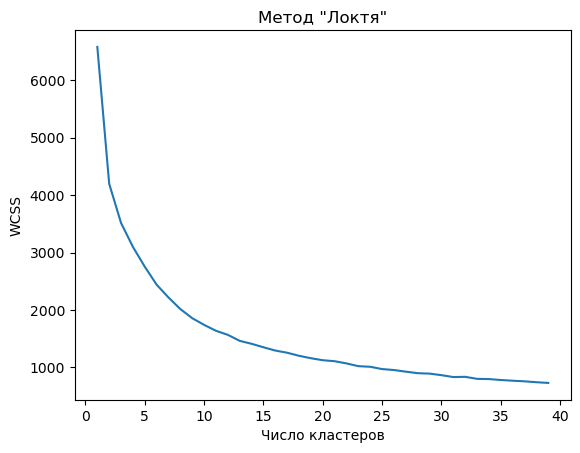

In [55]:
warnings.filterwarnings('ignore')
wcss = []
t_max = 40

# Применим k-средних для k от 1 до t_max
for i in range(1, t_max):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_boston_scaler)
    wcss.append(kmeans.inertia_)
# Визуализация результатов

plt.plot(range(1, t_max), wcss)
plt.title('Метод "Локтя"')
plt.xlabel('Число кластеров')
plt.ylabel('WCSS')
plt.show()

### Скорее всего число калстеров снова 20, хотя может быть и 25

## Проверим методом силуэтов

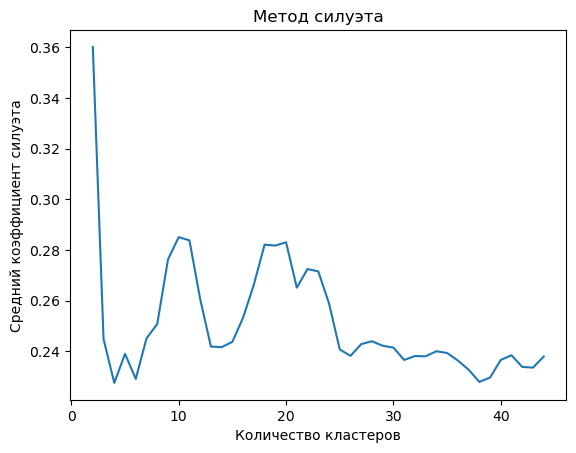

In [60]:
sil_scores_boston = []
for k in range(2, 45):  # Пробуем значения от 2 до 19 кластеров
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_boston_scaler)
    sil_scores_boston.append(silhouette_score(X_boston_scaler, kmeans.labels_))

# Строим график
plt.plot(range(2, 45), sil_scores_boston)  # Диапазон должен быть от 2 до 19
plt.title('Метод силуэта')
plt.xlabel('Количество кластеров')
plt.ylabel('Средний коэффициент силуэта')
plt.show()

## Исходя из графика у нас подходящее число кластеров 10 и 20. И т.к у нас и на локте было 20 сначала попробуем его

In [63]:
K=20

In [64]:
kmeans_boston = KMeans(n_clusters=K, random_state=42, n_init=10)
clusters_boston = kmeans_boston.fit_predict(X_boston_scaler) 

In [65]:
df_kmeans_boston = df_scaled_boston.copy()
df_kmeans_boston["Cluster"] = clusters_boston  # добавляем колонку кластеров

In [66]:
df_kmeans_boston

crim        zn     indus      chas       nox        rm       age  \
0   -0.419782  0.284830 -1.287909 -0.272599 -0.144217  0.413672 -0.120013   
1   -0.417339 -0.487722 -0.593381 -0.272599 -0.740262  0.194274  0.367166   
2   -0.417342 -0.487722 -0.593381 -0.272599 -0.740262  1.282714 -0.265812   
3   -0.416750 -0.487722 -1.306878 -0.272599 -0.835284  1.016303 -0.809889   
4   -0.412482 -0.487722 -1.306878 -0.272599 -0.835284  1.228577 -0.511180   
..        ...       ...       ...       ...       ...       ...       ...   
501 -0.413229 -0.487722  0.115738 -0.272599  0.158124  0.439316  0.018673   
502 -0.415249 -0.487722  0.115738 -0.272599  0.158124 -0.234548  0.288933   
503 -0.413447 -0.487722  0.115738 -0.272599  0.158124  0.984960  0.797449   
504 -0.407764 -0.487722  0.115738 -0.272599  0.158124  0.725672  0.736996   
505 -0.415000 -0.487722  0.115738 -0.272599  0.158124 -0.362767  0.434732   

          dis       rad       tax   ptratio         b     lstat  Cluster  
0    0.140214 -0.982843 -0.666608 -1.459000  0.441052 -1.075562       14  
1    0.557160 -0.867883 -0.987329 -0.303094  0.441052 -0.492439        4  
2    0.557160 -0.867883 -0.987329 -0.303094  0.396427 -1.208727       14  
3    1.077737 -0.752922 -1.106115  0.113032  0.416163 -1.361517       19  
4    1.077737 -0.752922 -1.106115  0.113032  0.441052 -1.026501       14  
..        ...       ...       ...       ...       ...       ...      ...  
501 -0.625796 -0.982843 -0.803212  1.176466  0.387217 -0.418147        4  
502 -0.716639 -0.982843 -0.803212  1.176466  0.441052 -0.500850        4  
503 -0.773684 -0.982843 -0.803212  1.176466  0.441052 -0.983048        4  
504 -0.668437 -0.982843 -0.803212  1.176466  0.403225 -0.865302        4  
505 -0.613246 -0.982843 -0.803212  1.176466  0.441052 -0.669058        4  

[506 rows x 14 columns]

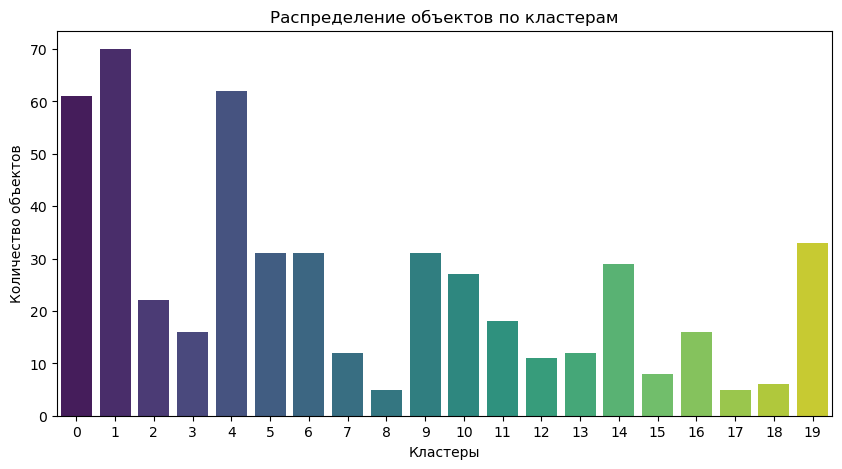

In [68]:
unique_boston, counts_boston = np.unique(clusters_boston, return_counts=True)

plt.figure(figsize=(10, 5))
sns.barplot(x=unique_boston, y=counts_boston, palette="viridis")

plt.xlabel("Кластеры")
plt.ylabel("Количество объектов")
plt.title("Распределение объектов по кластерам")
plt.xticks(unique_boston)
plt.show()

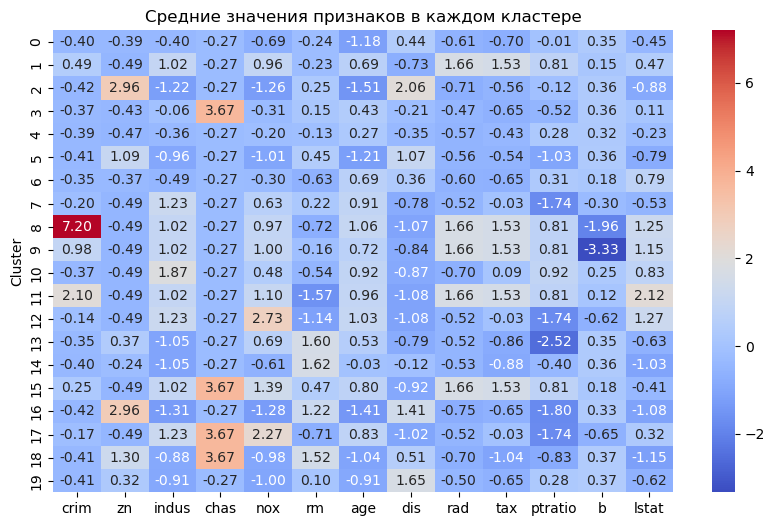

In [70]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_kmeans_boston.groupby("Cluster").mean(), cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Средние значения признаков в каждом кластере")
plt.show()

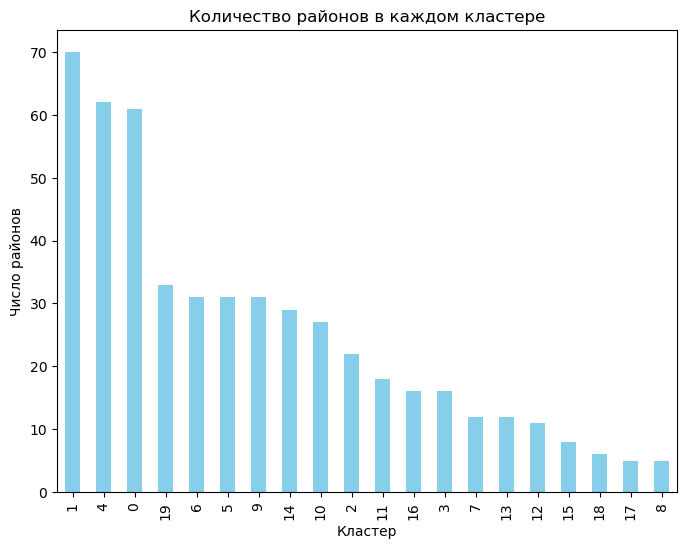

In [71]:
df_kmeans_boston["Cluster"].value_counts().plot(kind="bar", figsize=(8, 6), color="skyblue")
plt.title("Количество районов в каждом кластере")
plt.xlabel("Кластер")
plt.ylabel("Число районов")
plt.show()

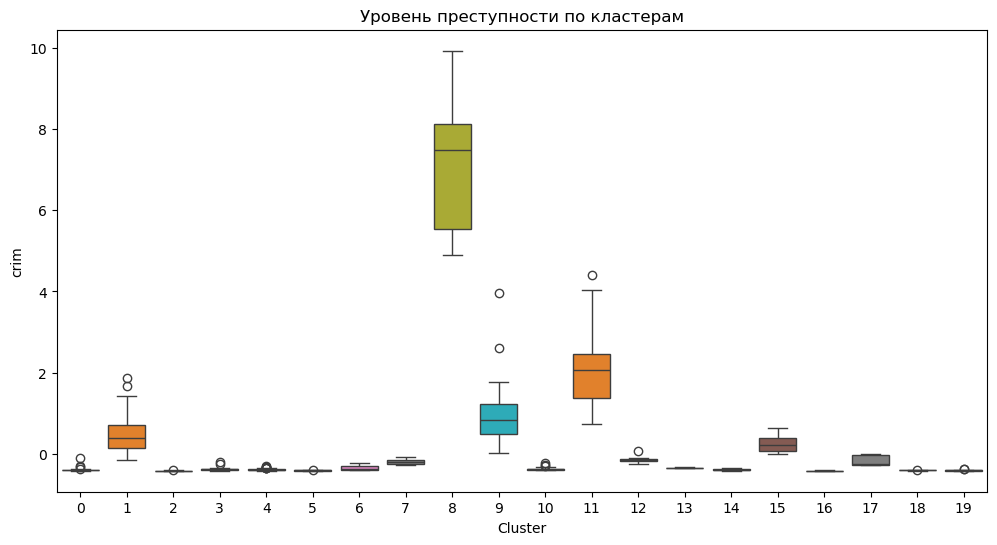

In [72]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Cluster", y="crim", data=df_kmeans_boston, palette="tab10")
plt.title("Уровень преступности по кластерам")
plt.show()

## Пока сложно понять какую -либо закономерность в кластерах данных. Попробуем проверить корреляцию и почистить данные

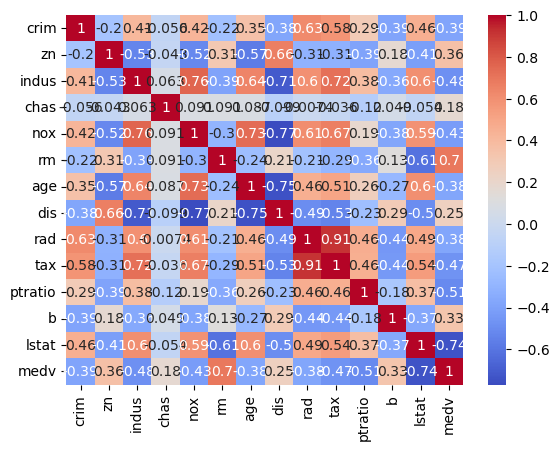

In [76]:
sns.heatmap(boston.corr(), annot=True, cmap="coolwarm")
plt.show()

In [77]:
boston.corr()

crim        zn     indus      chas       nox        rm       age  \
crim     1.000000 -0.200469  0.406583 -0.055892  0.420972 -0.219247  0.352734   
zn      -0.200469  1.000000 -0.533828 -0.042697 -0.516604  0.311991 -0.569537   
indus    0.406583 -0.533828  1.000000  0.062938  0.763651 -0.391676  0.644779   
chas    -0.055892 -0.042697  0.062938  1.000000  0.091203  0.091251  0.086518   
nox      0.420972 -0.516604  0.763651  0.091203  1.000000 -0.302188  0.731470   
rm      -0.219247  0.311991 -0.391676  0.091251 -0.302188  1.000000 -0.240265   
age      0.352734 -0.569537  0.644779  0.086518  0.731470 -0.240265  1.000000   
dis     -0.379670  0.664408 -0.708027 -0.099176 -0.769230  0.205246 -0.747881   
rad      0.625505 -0.311948  0.595129 -0.007368  0.611441 -0.209847  0.456022   
tax      0.582764 -0.314563  0.720760 -0.035587  0.668023 -0.292048  0.506456   
ptratio  0.289946 -0.391679  0.383248 -0.121515  0.188933 -0.355501  0.261515   
b       -0.385064  0.175520 -0.356977  0.048788 -0.380051  0.128069 -0.273534   
lstat    0.455621 -0.412995  0.603800 -0.053929  0.590879 -0.613808  0.602339   
medv    -0.388305  0.360445 -0.483725  0.175260 -0.427321  0.695360 -0.376955   

              dis       rad       tax   ptratio         b     lstat      medv  
crim    -0.379670  0.625505  0.582764  0.289946 -0.385064  0.455621 -0.388305  
zn       0.664408 -0.311948 -0.314563 -0.391679  0.175520 -0.412995  0.360445  
indus   -0.708027  0.595129  0.720760  0.383248 -0.356977  0.603800 -0.483725  
chas    -0.099176 -0.007368 -0.035587 -0.121515  0.048788 -0.053929  0.175260  
nox     -0.769230  0.611441  0.668023  0.188933 -0.380051  0.590879 -0.427321  
rm       0.205246 -0.209847 -0.292048 -0.355501  0.128069 -0.613808  0.695360  
age     -0.747881  0.456022  0.506456  0.261515 -0.273534  0.602339 -0.376955  
dis      1.000000 -0.494588 -0.534432 -0.232471  0.291512 -0.496996  0.249929  
rad     -0.494588  1.000000  0.910228  0.464741 -0.444413  0.488676 -0.381626  
tax     -0.534432  0.910228  1.000000  0.460853 -0.441808  0.543993 -0.468536  
ptratio -0.232471  0.464741  0.460853  1.000000 -0.177383  0.374044 -0.507787  
b        0.291512 -0.444413 -0.441808 -0.177383  1.000000 -0.366087  0.333461  
lstat   -0.496996  0.488676  0.543993  0.374044 -0.366087  1.000000 -0.737663  
medv     0.249929 -0.381626 -0.468536 -0.507787  0.333461 -0.737663  1.000000

In [84]:
# Рассчитаем VIF (коэффициент инфляции дисперсии)
vif_data = pd.DataFrame()
vif_data["Feature"] = X_boston.columns  # Исправил тут
vif_data["VIF"] = [variance_inflation_factor(X_boston_scaler, i) for i in range(X_boston_scaler.shape[1])]

# Выводим признаки с VIF > 10
vif_data[vif_data["VIF"] > 10]

Empty DataFrame
Columns: [Feature, VIF]
Index: []

## Данных в таблице нет, значит мультиколлинерарных данных у нас нет.

## Делаем PCA (Principal Component Analysis)

In [85]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_boston_scaler)

df_scaled_boston["PCA1"] = X_pca[:, 0]
df_scaled_boston["PCA2"] = X_pca[:, 1]

In [74]:
# Для простых номрмированных данных
test_hierarchical(X_boston_scaler)

Время выполнения для 506 точек: 0.011 сек


In [86]:
# Для простых PCA данных
test_hierarchical(X_pca)

Время выполнения для 506 точек: 0.011 сек


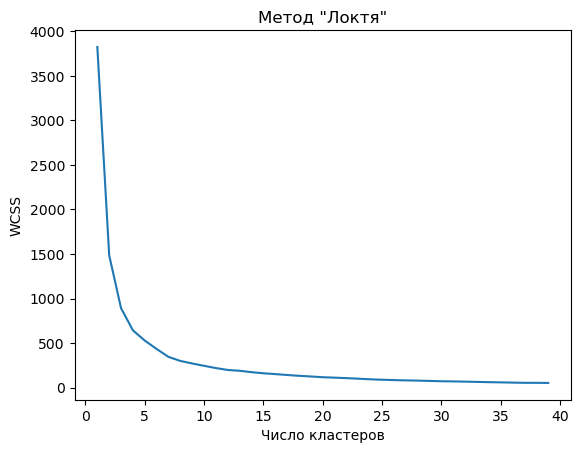

In [87]:
warnings.filterwarnings('ignore')
wcss = []
t_max = 40

# Применим k-средних для k от 1 до t_max
for i in range(1, t_max):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)
# Визуализация результатов

plt.plot(range(1, t_max), wcss)
plt.title('Метод "Локтя"')
plt.xlabel('Число кластеров')
plt.ylabel('WCSS')
plt.show()

## Судя по графику на PCA данных число кластеров = 4.

# Попробуем KMeans

In [88]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters_kmeans = kmeans.fit_predict(X_boston_scaler)

df_scaled_boston["Cluster_KMeans"] = clusters_kmeans

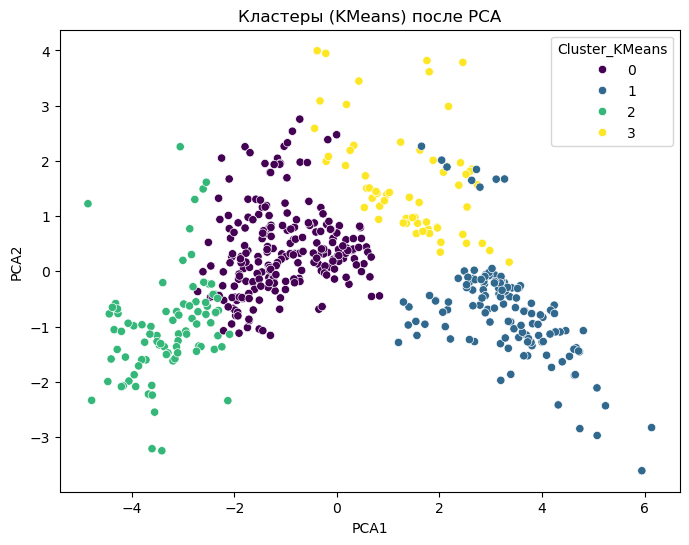

In [89]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_scaled_boston["PCA1"], y=df_scaled_boston["PCA2"], hue=df_scaled_boston["Cluster_KMeans"], palette='viridis')
plt.title('Кластеры (KMeans) после PCA')
plt.show()

## Судя по графику мы вполне приемлимо разщбили данны ена 4 кластера

## Используем DBSCAN

### Построим график расстояний для расчета eps

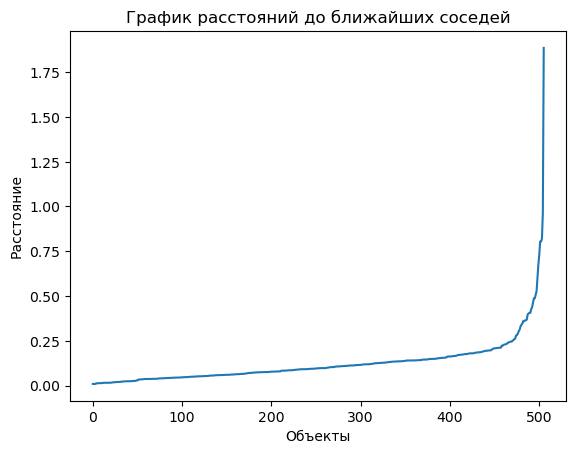

In [112]:
# Найдем расстояния до ближайших соседей
neighbors_boston = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors_boston.fit(X_pca)
distances_boston, indices_boston = neighbors_boston.kneighbors(X_pca)

# Сортируем расстояния по возрастанию
distances_boston = np.sort(distances_boston[:, 1], axis=0)

# Строим график
plt.plot(distances_boston)
plt.title('График расстояний до ближайших соседей')
plt.xlabel('Объекты')
plt.ylabel('Расстояние')
plt.show()

### Судя по графику приемлимым eps будет 0,4

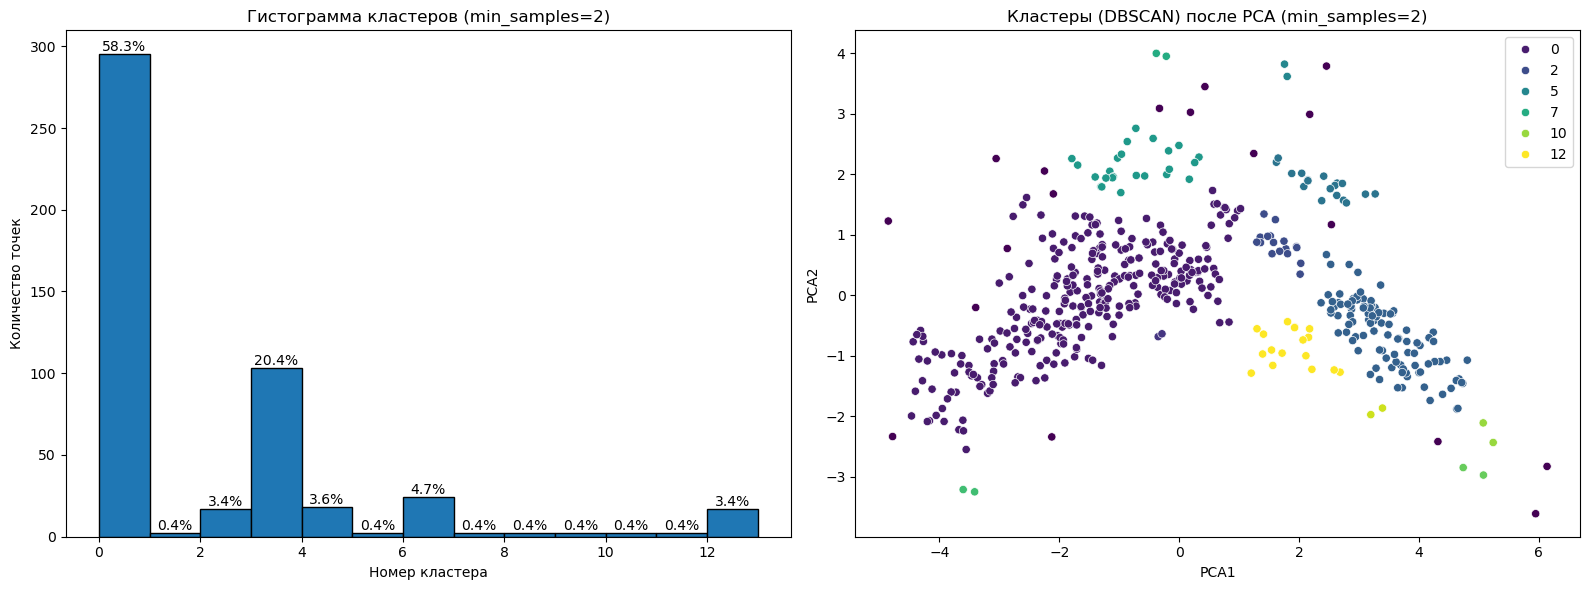

min_samples = 2: Количество кластеров = 13, Точки, классифицированные как шум: 18


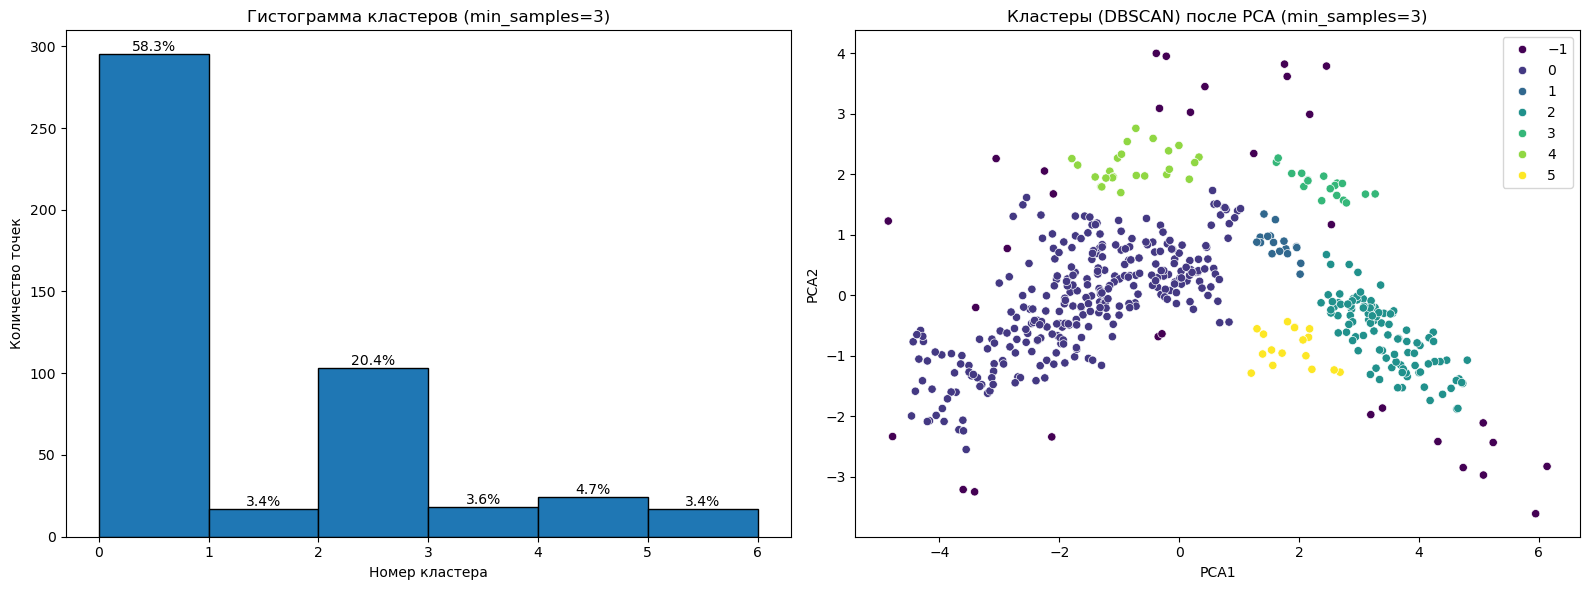

min_samples = 3: Количество кластеров = 6, Точки, классифицированные как шум: 32


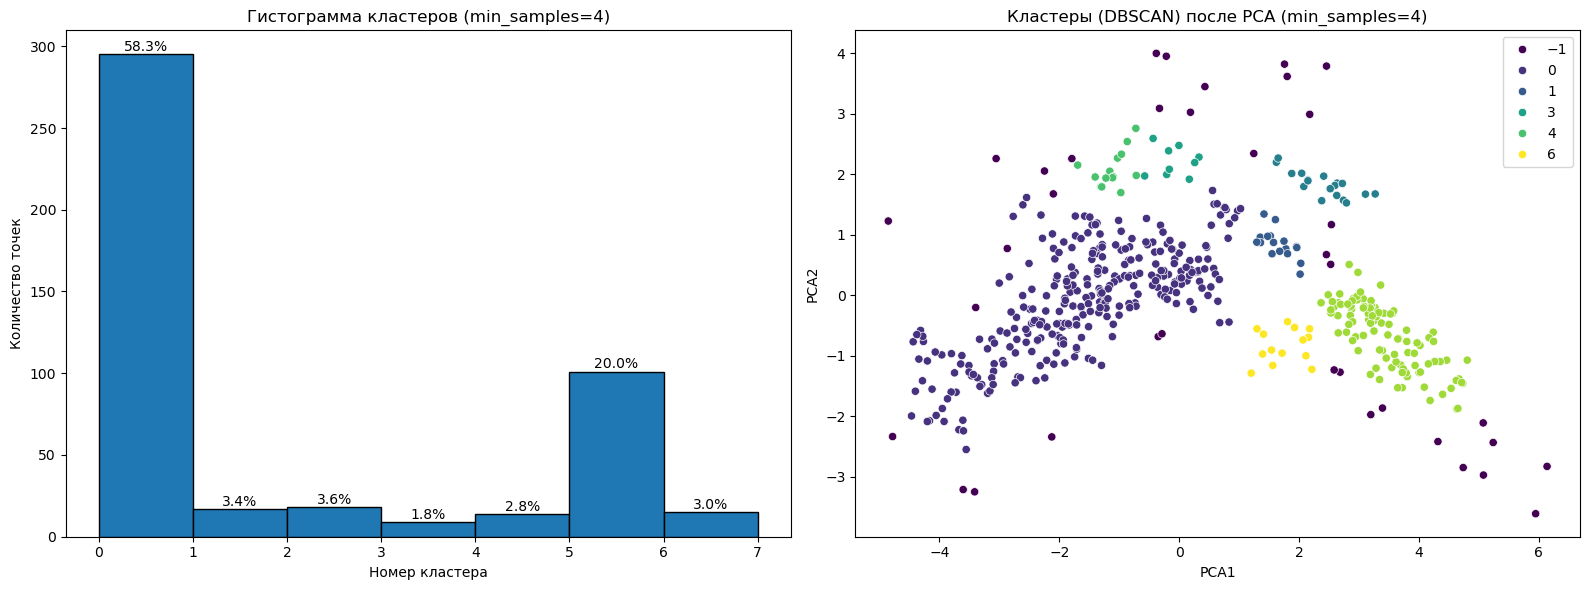

min_samples = 4: Количество кластеров = 7, Точки, классифицированные как шум: 37


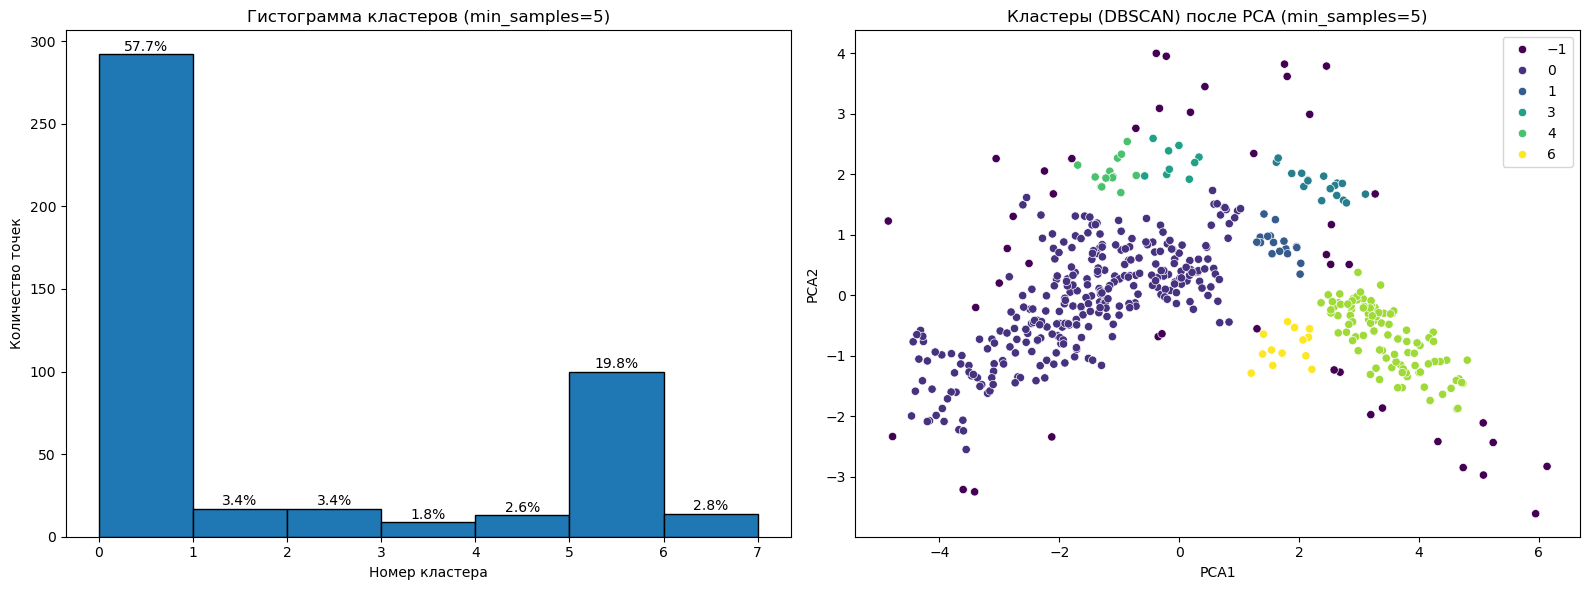

min_samples = 5: Количество кластеров = 7, Точки, классифицированные как шум: 44


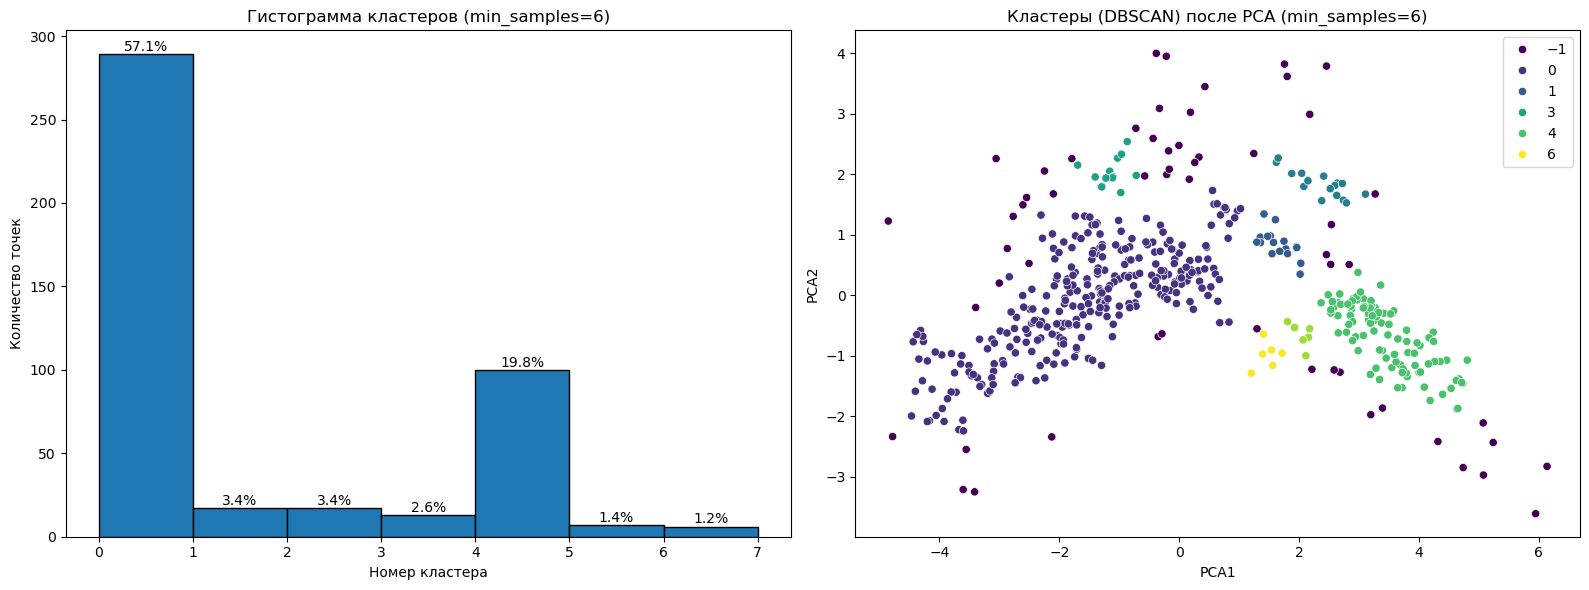

min_samples = 6: Количество кластеров = 7, Точки, классифицированные как шум: 57


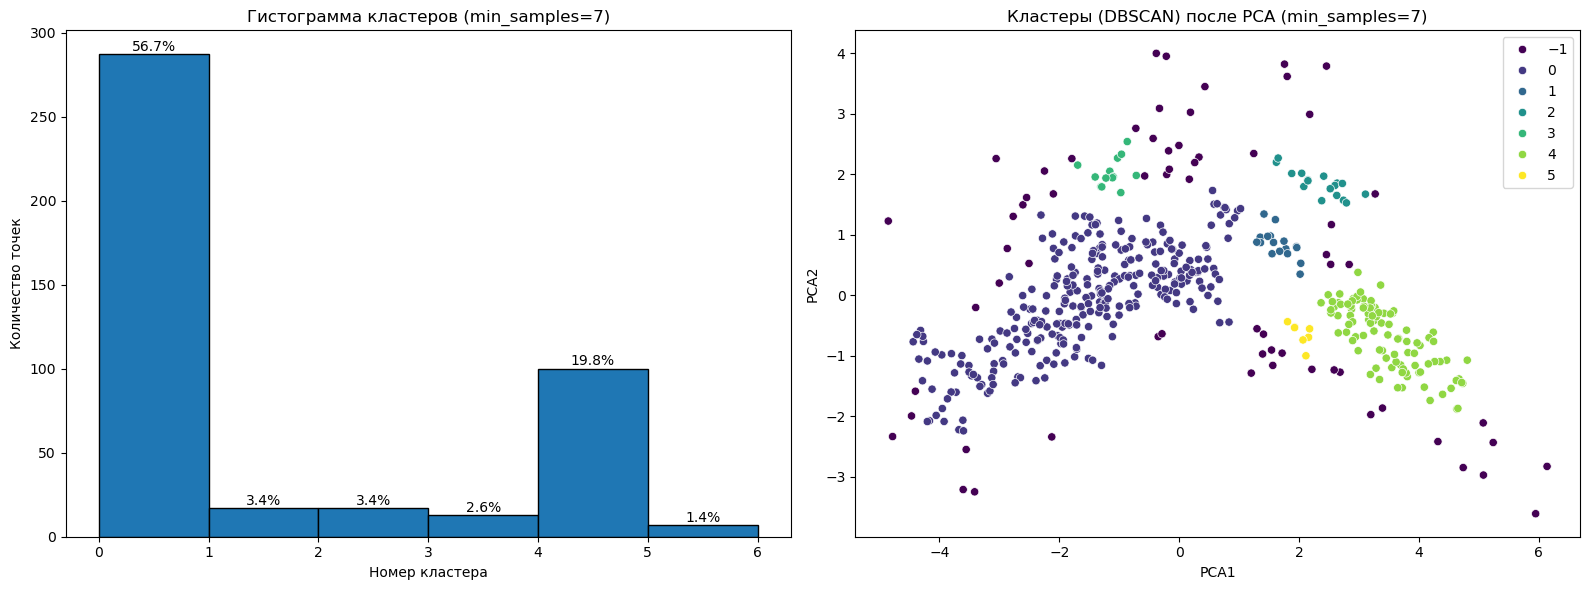

min_samples = 7: Количество кластеров = 6, Точки, классифицированные как шум: 65


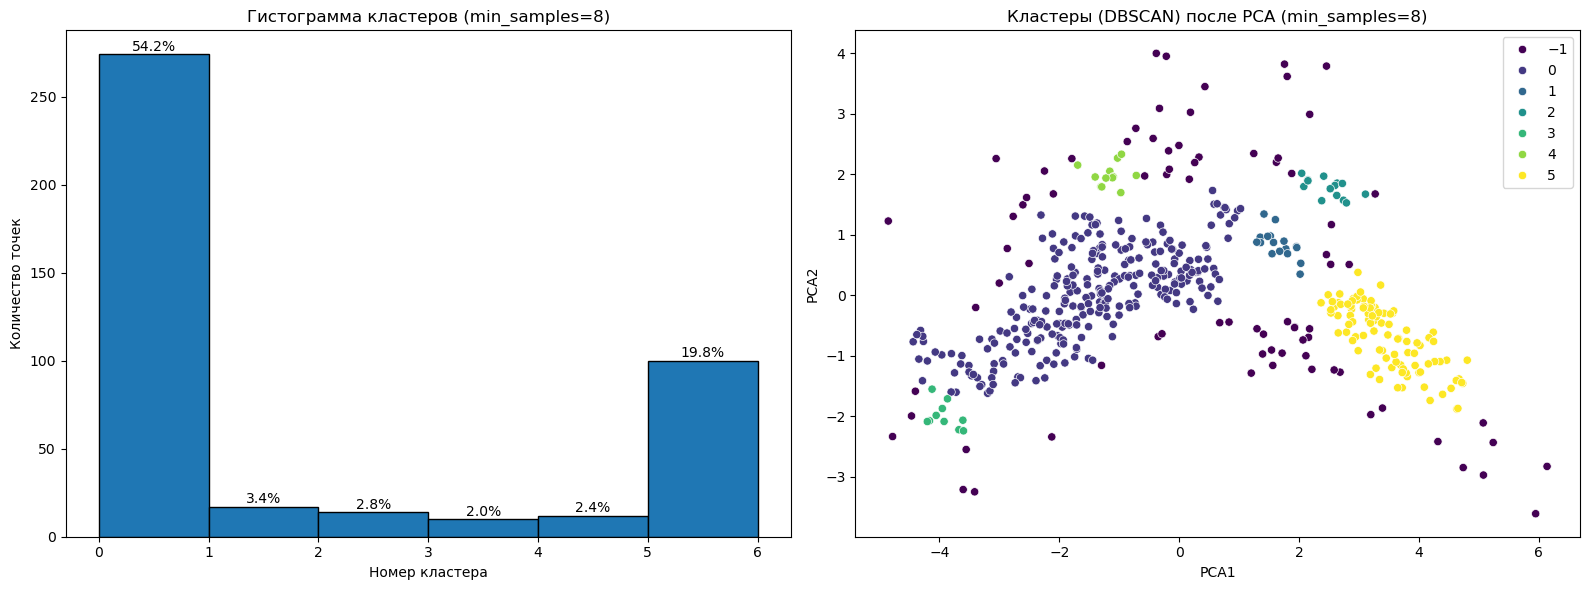

min_samples = 8: Количество кластеров = 6, Точки, классифицированные как шум: 79


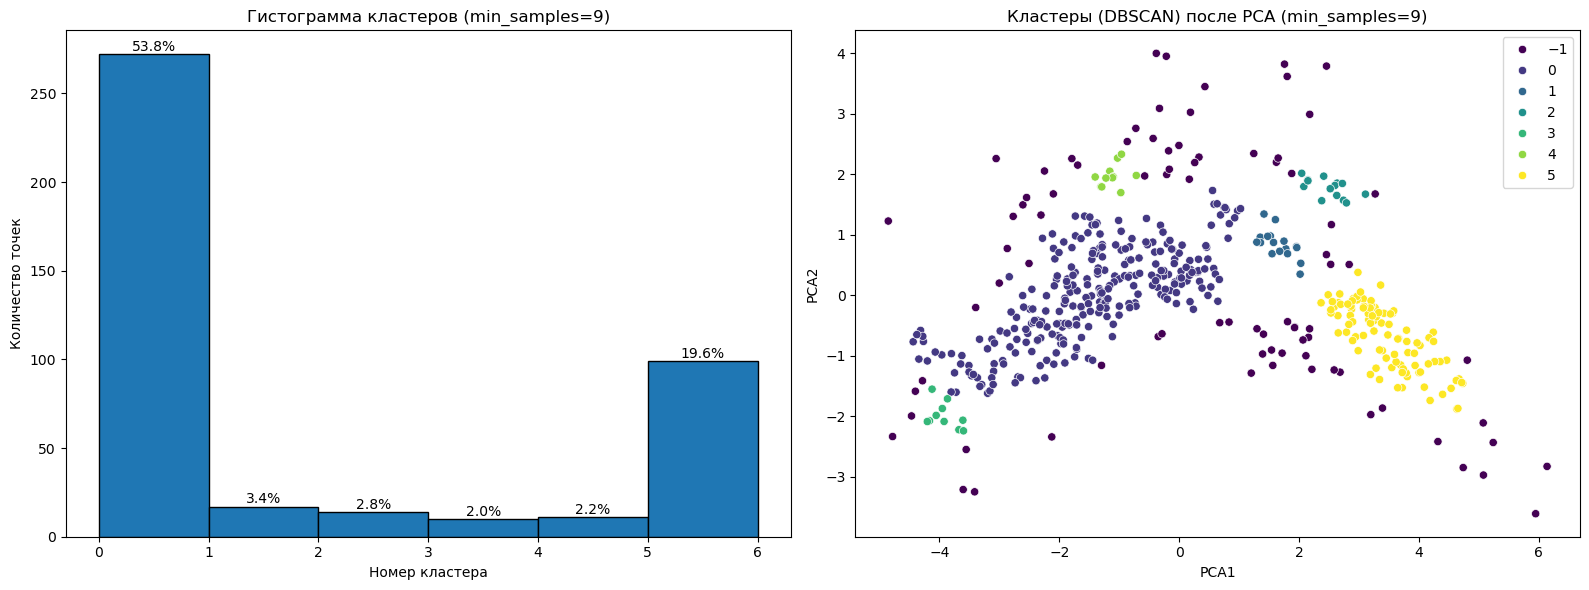

min_samples = 9: Количество кластеров = 6, Точки, классифицированные как шум: 83


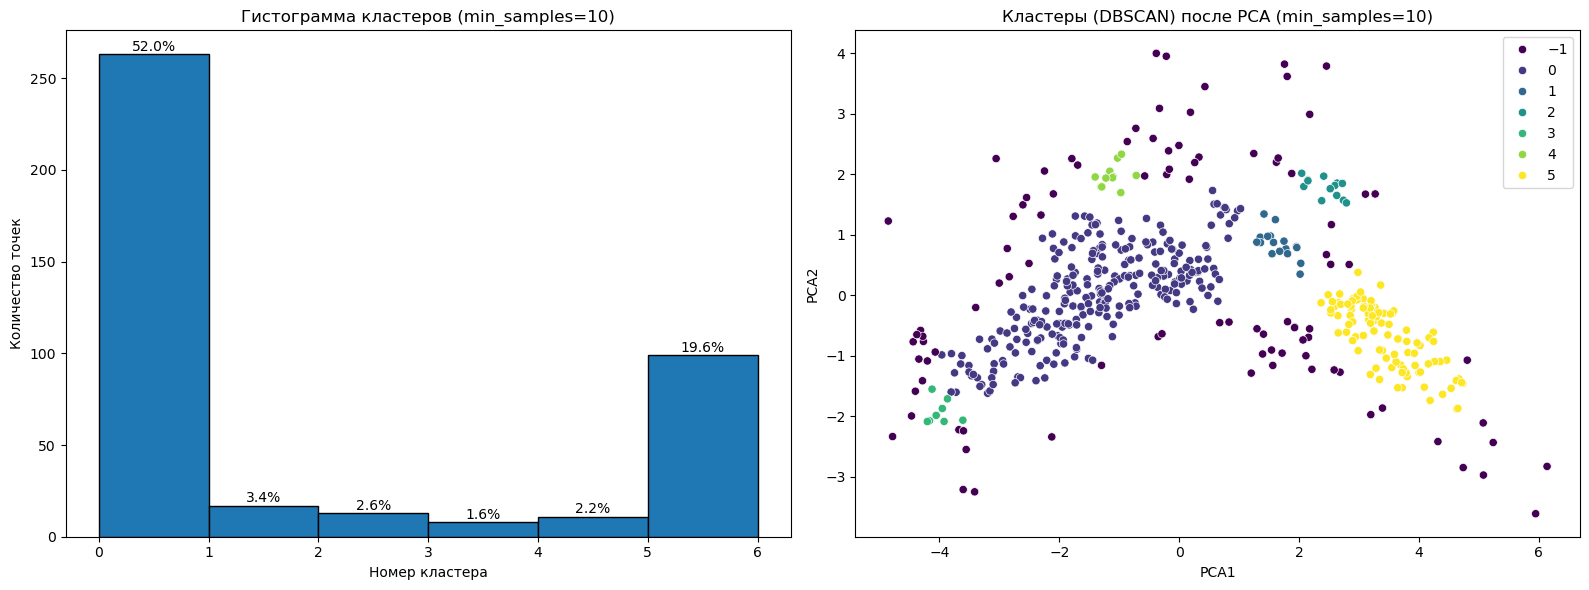

min_samples = 10: Количество кластеров = 6, Точки, классифицированные как шум: 95


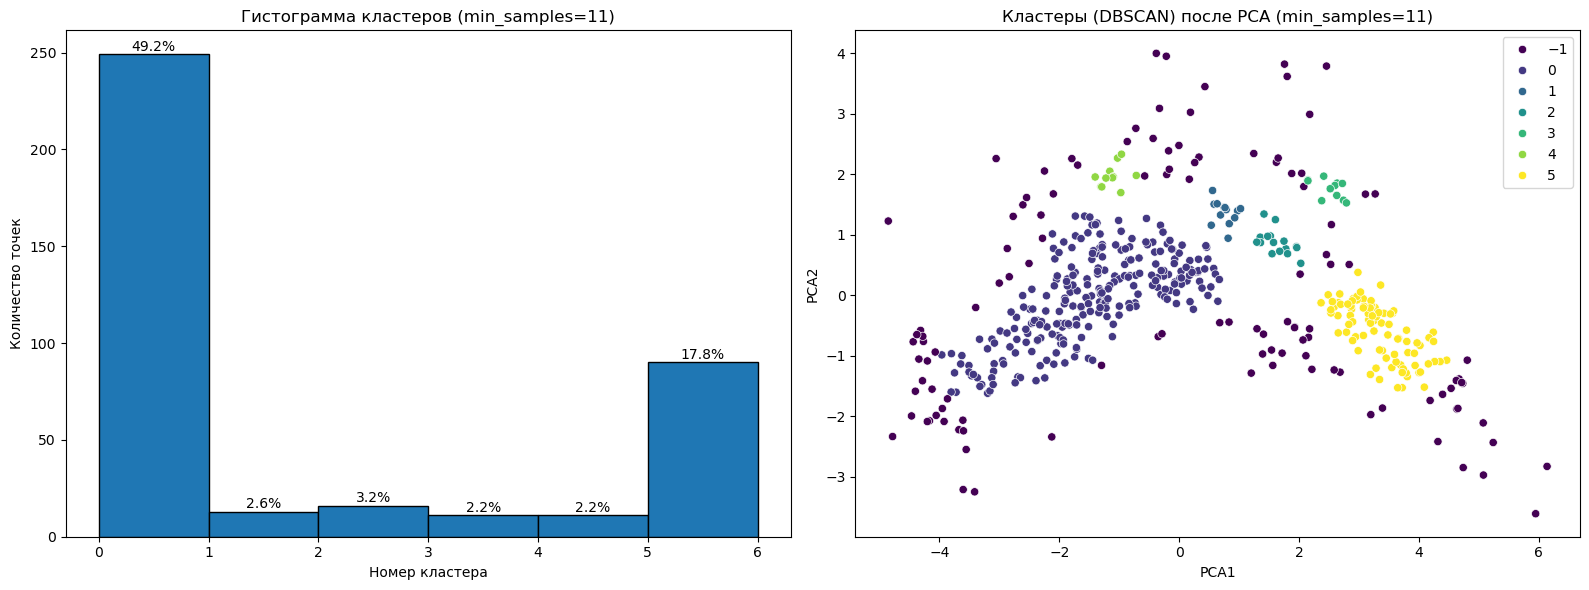

min_samples = 11: Количество кластеров = 6, Точки, классифицированные как шум: 116


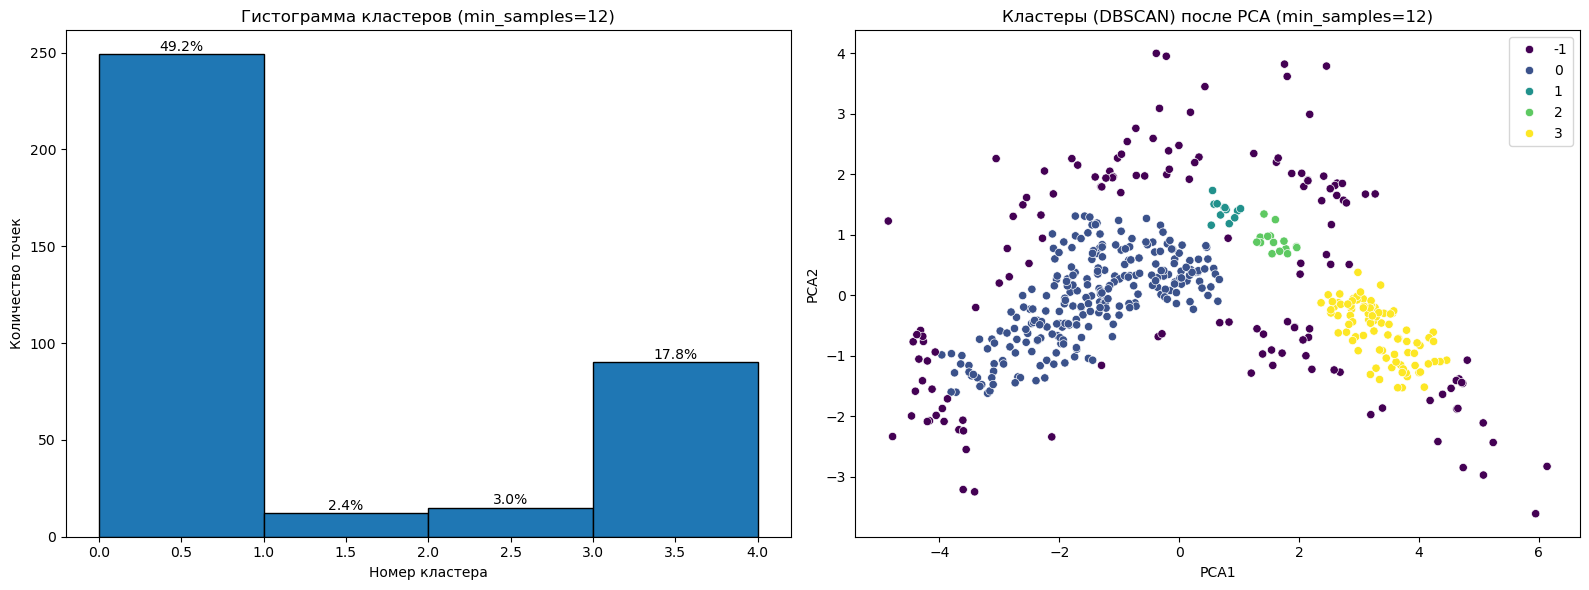

min_samples = 12: Количество кластеров = 4, Точки, классифицированные как шум: 140


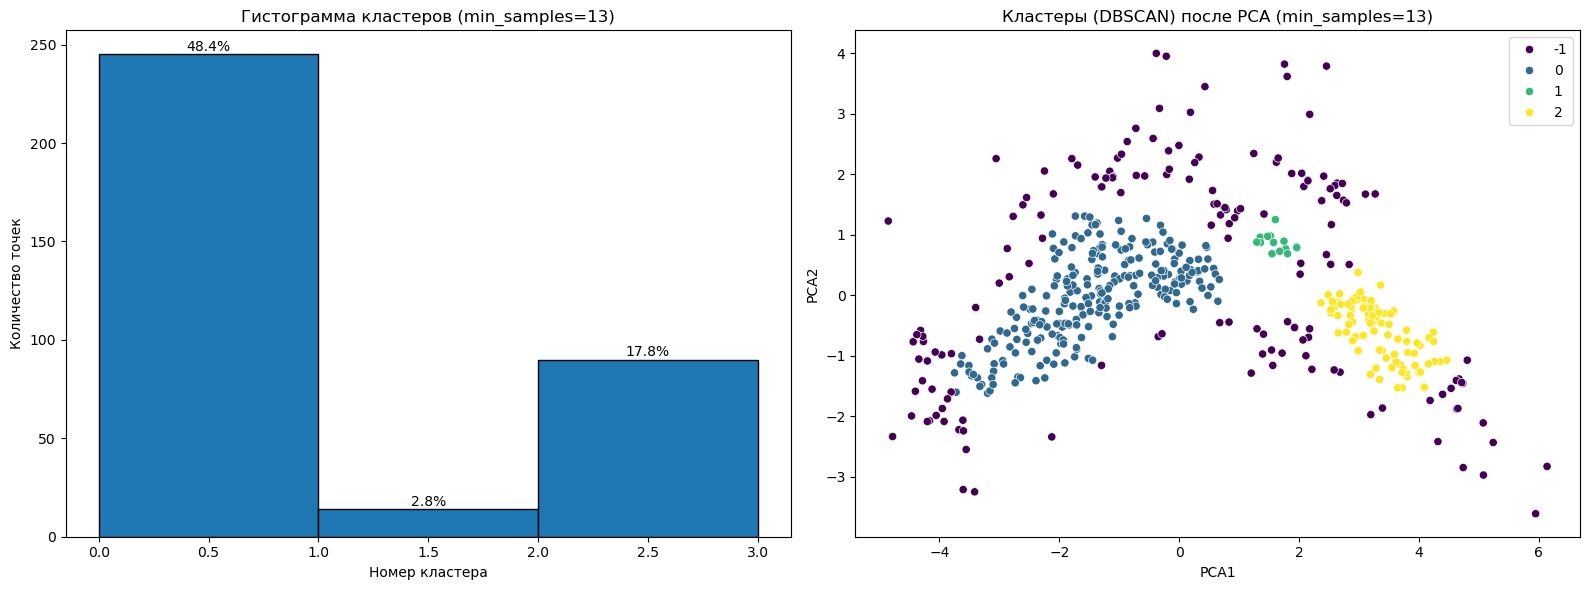

min_samples = 13: Количество кластеров = 3, Точки, классифицированные как шум: 157


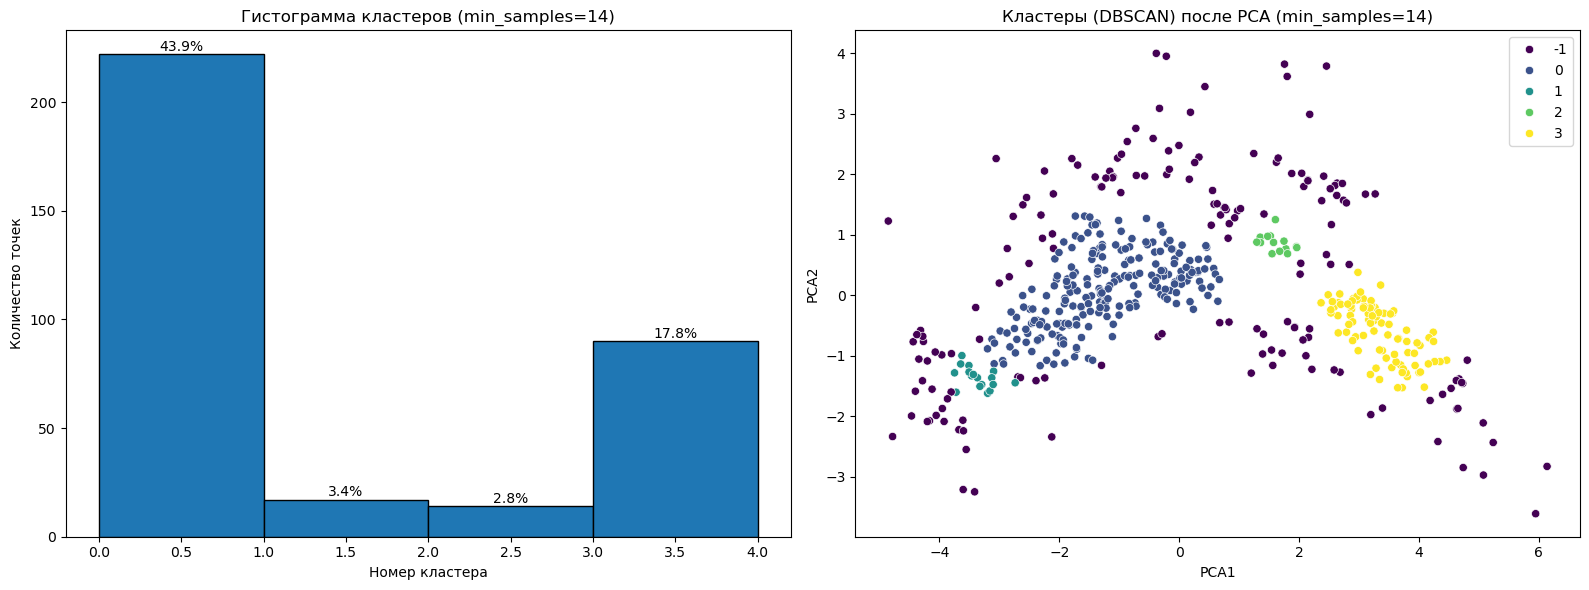

min_samples = 14: Количество кластеров = 4, Точки, классифицированные как шум: 163


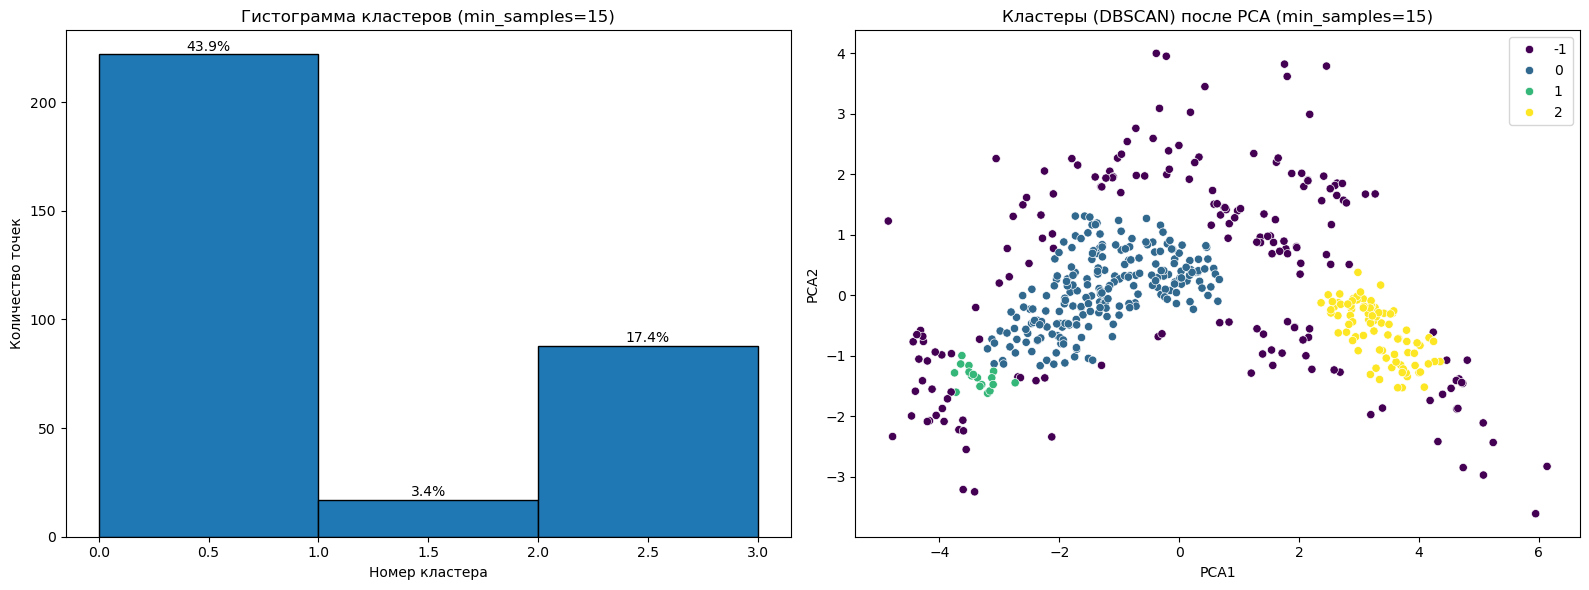

min_samples = 15: Количество кластеров = 3, Точки, классифицированные как шум: 179


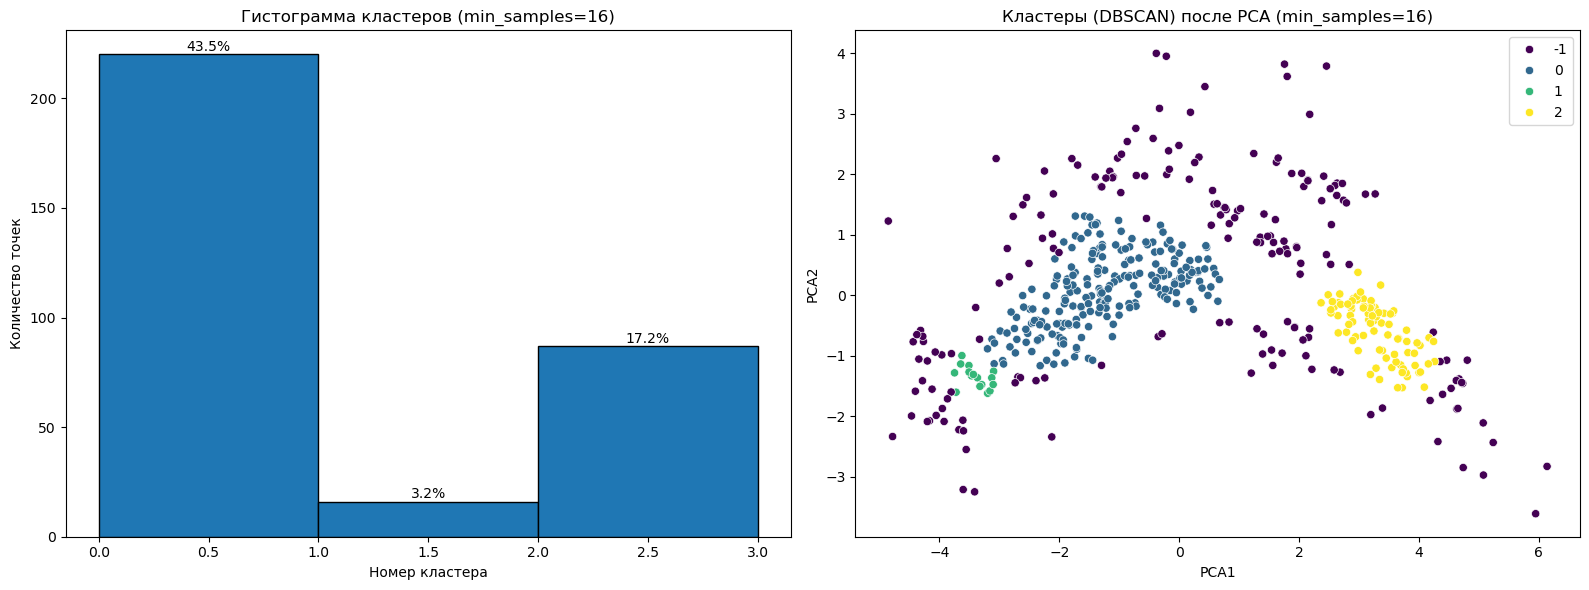

min_samples = 16: Количество кластеров = 3, Точки, классифицированные как шум: 183


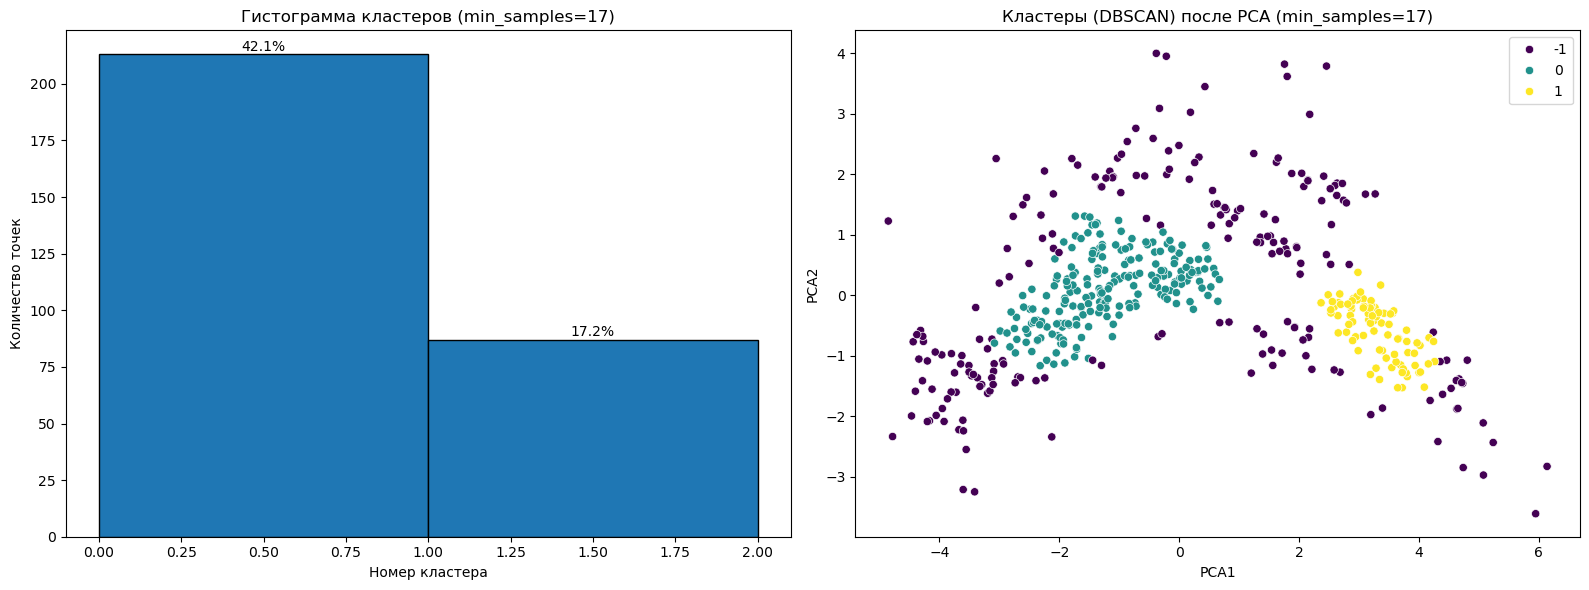

min_samples = 17: Количество кластеров = 2, Точки, классифицированные как шум: 206


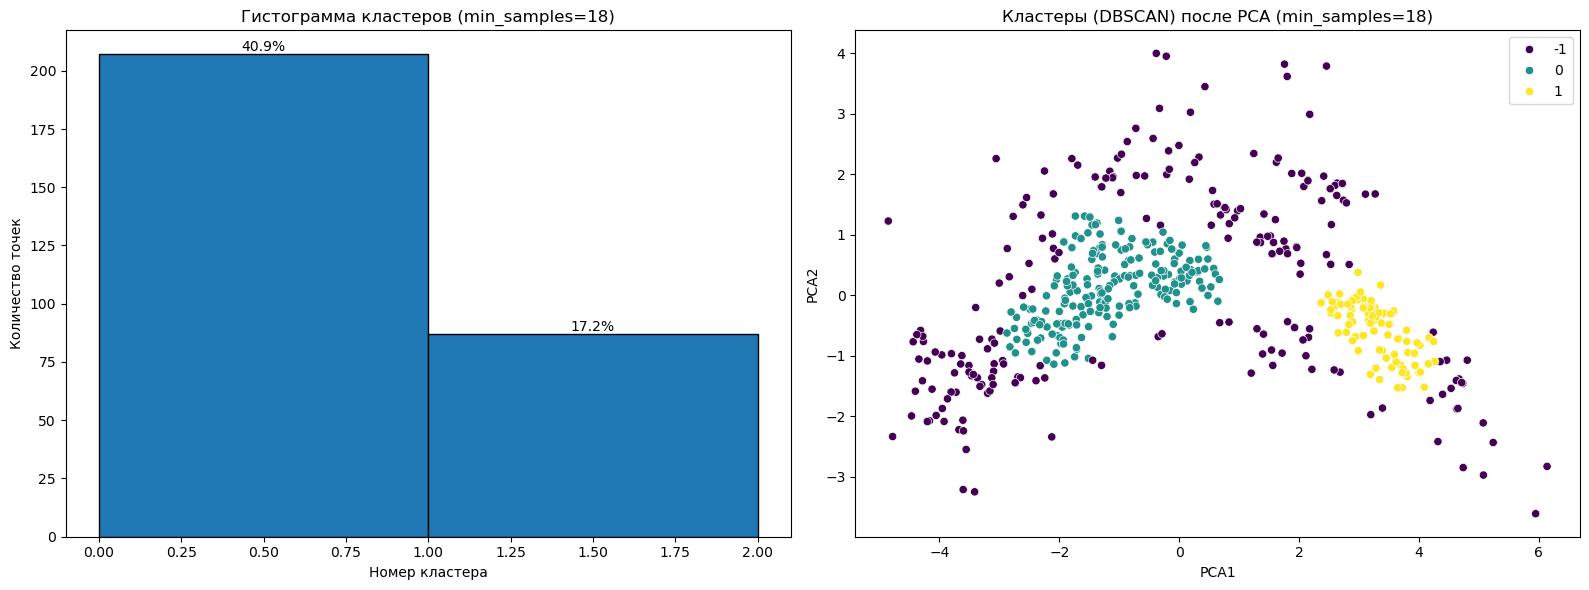

min_samples = 18: Количество кластеров = 2, Точки, классифицированные как шум: 212


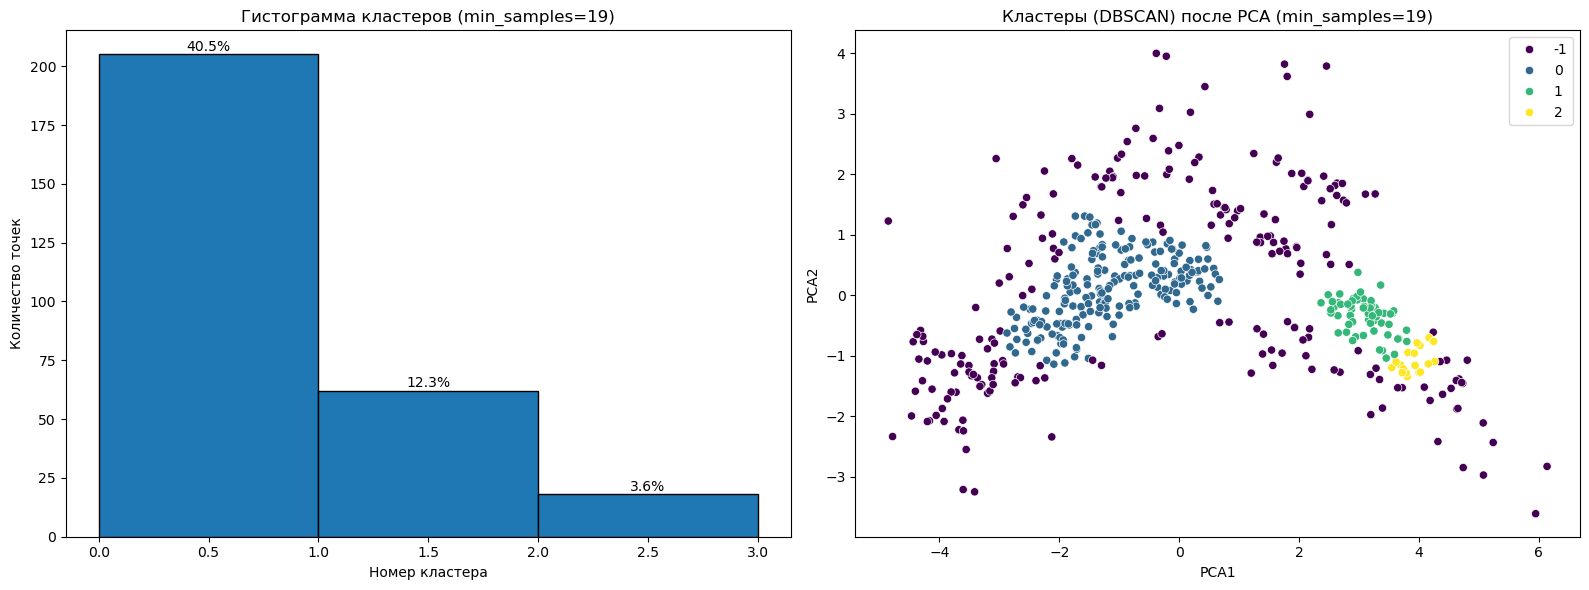

min_samples = 19: Количество кластеров = 3, Точки, классифицированные как шум: 221
min_samples = 2: 13 кластеров, шумных точек: 18
min_samples = 3: 6 кластеров, шумных точек: 32
min_samples = 4: 7 кластеров, шумных точек: 37
min_samples = 5: 7 кластеров, шумных точек: 44
min_samples = 6: 7 кластеров, шумных точек: 57
min_samples = 7: 6 кластеров, шумных точек: 65
min_samples = 8: 6 кластеров, шумных точек: 79
min_samples = 9: 6 кластеров, шумных точек: 83
min_samples = 10: 6 кластеров, шумных точек: 95
min_samples = 11: 6 кластеров, шумных точек: 116
min_samples = 12: 4 кластеров, шумных точек: 140
min_samples = 13: 3 кластеров, шумных точек: 157
min_samples = 14: 4 кластеров, шумных точек: 163
min_samples = 15: 3 кластеров, шумных точек: 179
min_samples = 16: 3 кластеров, шумных точек: 183
min_samples = 17: 2 кластеров, шумных точек: 206
min_samples = 18: 2 кластеров, шумных точек: 212
min_samples = 19: 3 кластеров, шумных точек: 221


In [113]:
min_samples_values = range(2, 20)  # Пробуем значения от 2 до 20 для min_samples
eps = 0.4

cluster_counts_boston = []

# Проходим по всем значениям min_samples
for min_samples in min_samples_values:
    # Инициализируем DBSCAN с текущими значениями
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    
    # Применяем алгоритм кластеризации
    clusters = dbscan.fit_predict(X_pca)

    # Получаем количество кластеров (кроме шума)
    unique_clusters = set(clusters)
    num_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)  # Минус 1, если есть шум

    # Добавляем информацию в список
    cluster_counts_boston.append((min_samples, num_clusters, clusters))

    # Подсчитываем количество точек в каждом кластере
    cluster_counts_dict = Counter(clusters)
    total_points = len(clusters)

    # Создаем фигуру с двумя подграфиками (гистограмма слева и scatterplot справа)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Гистограмма для кластеров
    n, bins, patches = axes[0].hist(clusters[clusters != -1], bins=range(num_clusters + 1), edgecolor='black')  # Игнорируем шум
    axes[0].set_title(f'Гистограмма кластеров (min_samples={min_samples})')
    axes[0].set_xlabel('Номер кластера')
    axes[0].set_ylabel('Количество точек')

    # Добавляем проценты в каждый столбец
    for i in range(len(n)):  # Используем len(n), чтобы избежать выхода за пределы
        percentage = (n[i] / total_points) * 100
        axes[0].text(bins[i] + 0.5, n[i] + 0.2, f'{percentage:.1f}%', ha='center', va='bottom', fontsize=10)

    # Scatterplot для кластеров после PCA
    sns.scatterplot(x=df_scaled_boston["PCA1"], y=df_scaled_boston["PCA2"], hue=clusters, palette='viridis', ax=axes[1])
    axes[1].set_title(f'Кластеры (DBSCAN) после PCA (min_samples={min_samples})')

    # Показываем график
    plt.tight_layout()
    plt.show()

    # Выводим информацию о кластерах
    print(f"min_samples = {min_samples}: Количество кластеров = {num_clusters}, "
          f"Точки, классифицированные как шум: {sum(clusters == -1)}")

# Печатаем количество кластеров для каждого min_samples
for min_samples, num_clusters, clusters in cluster_counts_boston:
    print(f"min_samples = {min_samples}: {num_clusters} кластеров, "
          f"шумных точек: {sum(clusters == -1)}")

### По данным сложно чтото предположить довольно много шумных точкек. Или же много мелких кластеров. На мой взгляд оптимальнее всего вылядят 4-6 калстерные варианта

## Попробуем иерархическую кластеризацию

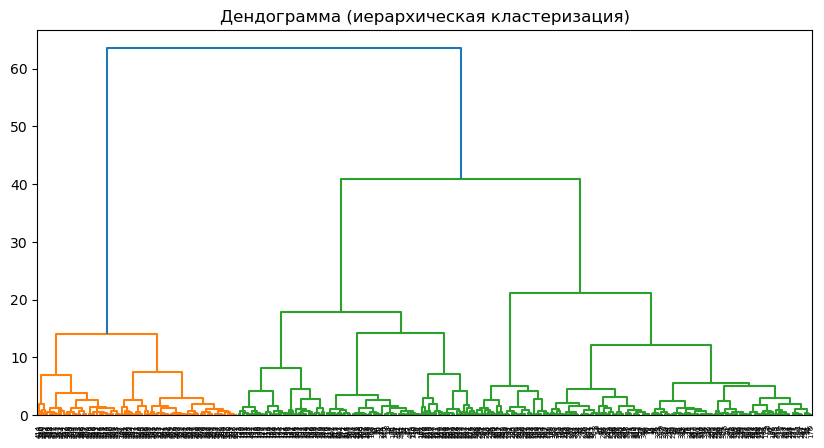

In [114]:
Z = linkage(X_pca, method='ward')  

plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title('Дендограмма (иерархическая кластеризация)')
plt.show()

### Попробуем разбивку на 3 кластера (т.е срез на 25)

In [117]:
clusters_hierarchical_25 = fcluster(Z, 3, criterion='maxclust')
df_scaled_boston["Cluster_Hierarchical_25"] = clusters_hierarchical_25

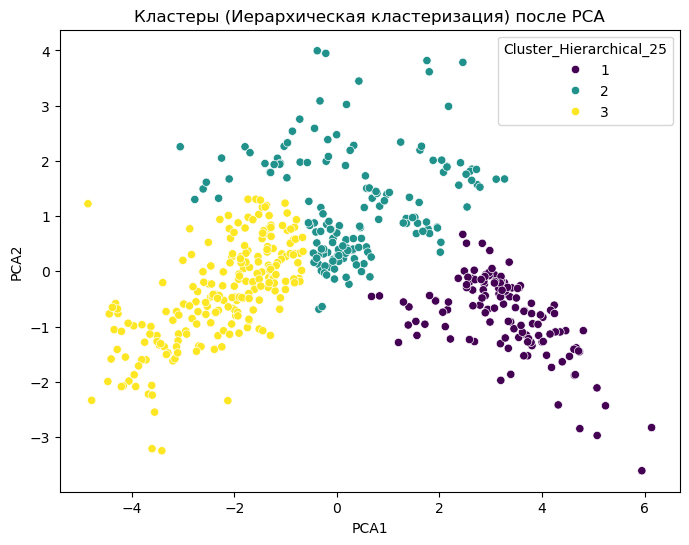

In [118]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_scaled_boston["PCA1"], y=df_scaled_boston["PCA2"], hue=df_scaled_boston["Cluster_Hierarchical_25"], palette='viridis')
plt.title('Кластеры (Иерархическая кластеризация) после PCA')
plt.show()

#### Попробуем разбивку на 4 кластера (т.е срез на 18)

In [119]:
clusters_hierarchical_18 = fcluster(Z, 4, criterion='maxclust')
df_scaled_boston["Cluster_Hierarchical_18"] = clusters_hierarchical_18

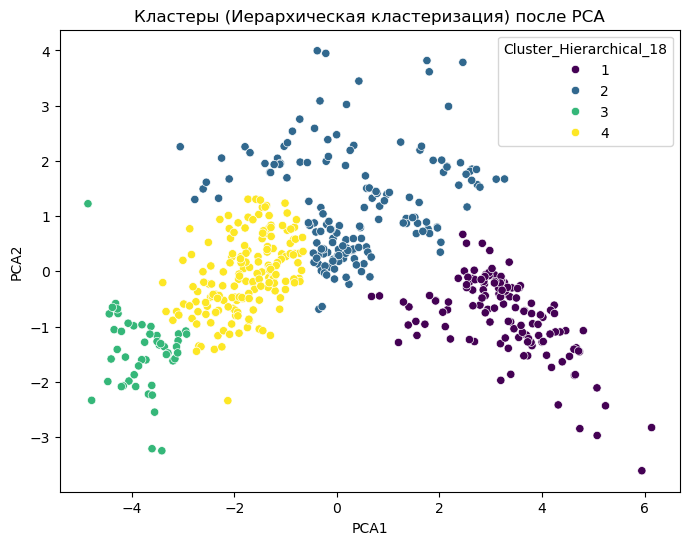

In [121]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_scaled_boston["PCA1"], y=df_scaled_boston["PCA2"], hue=df_scaled_boston["Cluster_Hierarchical_18"], palette='viridis')
plt.title('Кластеры (Иерархическая кластеризация) после PCA')
plt.show()

## График получился похожим на графки у K-means а близкая разбивка разными методами показывае что мы это правильная разбивка.

In [129]:
pd.set_option('display.max_columns', 18)
pd.set_option('display.expand_frame_repr', False)

In [133]:
df_clusters_boston = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])  
df_scaled_boston["Cluster_Hierarchical_18"] = clusters_hierarchical_18

for cluster_num in np.unique(clusters_hierarchical_18):
    cluster_data = df_scaled_boston[df_scaled_boston['Cluster_Hierarchical_18'] == cluster_num]
    
    print(f"Кластер {cluster_num}:\n")
    print(cluster_data.drop(columns=['Cluster_Hierarchical_30','Cluster_Hierarchical','Cluster_Hierarchical_25']))  # Выводим все фичи для объектов в кластере
    
    # Сначала создаем список для хранения модальных значений
    mode_values = {}
    
    # Для каждого признака находим самое частое значение и среднее
    for column in cluster_data.drop(columns=['Cluster_Hierarchical_30','Cluster_Hierarchical','Cluster_Hierarchical_25']).columns:
        # Находим самое частое значение (модальное) и его процентное соотношение
        mode_value = cluster_data[column].mode()[0]  # Самое частое значение
        mode_percent = (cluster_data[column].value_counts(normalize=True).max()) * 100  # Процентное соотношение
        
        # Среднее значение признака
        mean_value = cluster_data[column].mean()
        
        # Сохраняем модальные и средние значения в словарь
        mode_values[column] = (mode_value, mean_value)
    
    # Выводим модальные значения (самое частое) и средние значения
    print(f"\nСамые частые значения и средние для Кластера {cluster_num}:")
    for column, (mode_value, mean_value) in mode_values.items():
        print(f"  {column}:")
        print(f"    Самое частое значение: {mode_value} ({(cluster_data[column].value_counts(normalize=True).max()) * 100:.2f}%)")
        print(f"    Среднее значение: {mean_value:.2f}")
    
    print("\n" + "="*40 + "\n")

Кластер 1:

         crim        zn     indus      chas       nox        rm       age       dis       rad       tax   ptratio         b     lstat      PCA1      PCA2  Cluster_KMeans  Cluster_Hierarchical_18
32  -0.258993 -0.487722 -0.437258 -0.272599 -0.144217 -0.476740  0.477404  0.092677 -0.637962 -0.601276  1.176466 -1.360392  2.110588  0.831255 -0.444120               0                        1
102 -0.393896 -0.487722 -0.375976 -0.272599 -0.299707  0.171480  0.598310 -0.513562 -0.523001 -0.143951  1.130230 -3.134425 -0.283580  0.676062 -0.454480               0                        1
141 -0.230987 -0.487722  1.568995 -0.272599  0.598679 -1.803097  1.117494 -1.119800 -0.637962  0.170831  1.268938  0.441052  3.049752  2.835701  0.507167               3                        1
359  0.075385 -0.487722  1.015999 -0.272599  1.859875 -0.245945  0.452512 -0.611297  1.661245  1.530926  0.806576  0.373511  0.002374  2.657126 -0.125862               1                        1
360  0.108040

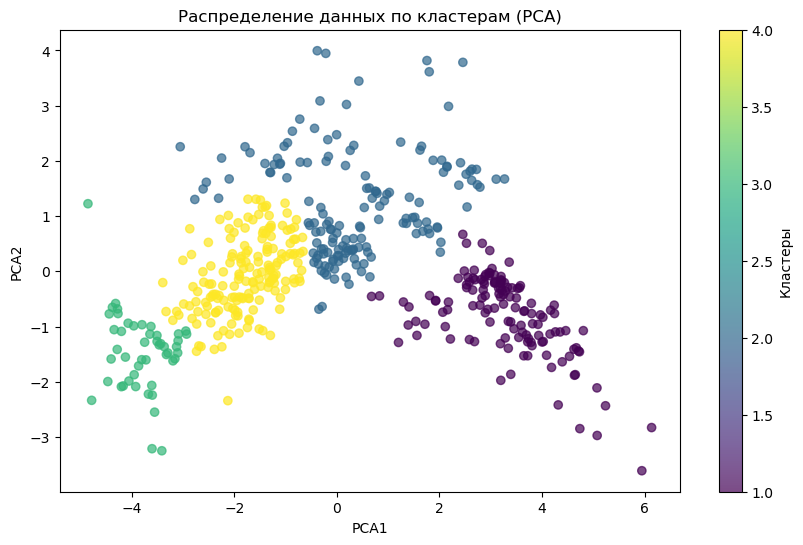

In [135]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_scaled_boston["PCA1"], df_scaled_boston["PCA2"], 
                      c=df_scaled_boston["Cluster_Hierarchical_18"], cmap="viridis", alpha=0.7)
plt.colorbar(scatter, label="Кластеры")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("Распределение данных по кластерам (PCA)")
plt.show()

In [140]:
# Коэффициенты проекции исходных признаков на главные компоненты
pca_components = pca.components_

# Определяем количество исходных признаков в X_boston_scaler
feature_names = df_scaled_boston.columns[:X_boston_scaler.shape[1]]

# Создаем DataFrame с правильными именами столбцов
pca_df = pd.DataFrame(pca_components, columns=feature_names, index=["PCA1", "PCA2"])

# Анализ влияния фич на главные компоненты
print(pca_df.T.sort_values(by="PCA1", ascending=False))  # Влияние на первую компоненту
print(pca_df.T.sort_values(by="PCA2", ascending=False))  # Влияние на вторую компоненту

             PCA1      PCA2
indus    0.346672  0.112493
nox      0.342852  0.219116
tax      0.338469 -0.239454
rad      0.319793 -0.271521
age      0.313671  0.311978
lstat    0.309760 -0.074322
crim     0.250951 -0.315252
ptratio  0.204942 -0.305897
chas     0.005042  0.454829
rm      -0.189243  0.149332
b       -0.202973  0.238559
zn      -0.256315 -0.323313
dis     -0.321544 -0.349070
             PCA1      PCA2
chas     0.005042  0.454829
age      0.313671  0.311978
b       -0.202973  0.238559
nox      0.342852  0.219116
rm      -0.189243  0.149332
indus    0.346672  0.112493
lstat    0.309760 -0.074322
tax      0.338469 -0.239454
rad      0.319793 -0.271521
ptratio  0.204942 -0.305897
crim     0.250951 -0.315252
zn      -0.256315 -0.323313
dis     -0.321544 -0.349070


In [142]:
# Определяем названия исходных признаков
feature_names = df_scaled_boston.columns[:X_reconstructed.shape[1]]

# Создаем DataFrame
df_reconstructed = pd.DataFrame(X_reconstructed, columns=feature_names)

# Добавляем колонку с кластерами
df_reconstructed["Cluster"] = df_scaled_boston["Cluster_Hierarchical_18"]

# Выводим средние значения признаков по кластерам
print(df_reconstructed.groupby("Cluster").mean())


             crim        zn     indus      chas       nox        rm       age       dis       rad       tax   ptratio         b     lstat
Cluster                                                                                                                                  
1        1.075544 -0.581995  1.047147 -0.347529  0.949271 -0.740308  0.779214 -0.775350  1.266360  1.301956  0.917131 -0.856769  1.075600
2       -0.290517 -0.485272  0.262744  0.553015  0.390560  0.111953  0.492451 -0.540272 -0.212418 -0.166747 -0.295958  0.215075  0.022895
3       -0.488956  1.442893 -1.476671 -0.684086 -1.618104  0.497971 -1.643420  1.727454 -0.813468 -0.931046 -0.328484  0.419482 -1.063814
4       -0.420908  0.477904 -0.622218 -0.042761 -0.623385  0.323983 -0.578621  0.595321 -0.546058 -0.581513 -0.340136  0.341657 -0.542961


### Анализ кластеров
- Кластер 1 
Высокий уровень преступности (crim = 1.07, самый высокий)
Высокая доля промышленной зоны (indus = 1.04)
Высокое загрязнение воздуха (nox = 0.95)
Высокие налоги (tax = 1.30)
Плохие школы (ptratio = 0.91)
Много бедного населения (lstat = 1.07)
Мало зелени, плохая экология

Гиппотеза: это бедные промышленные районы с плохой экологией и высокой преступностью.

 Кластер 2 (средний класс, стабильный район)
Средний уровень преступности (crim = -0.29)
Промышленная зона присутствует, но меньше (indus = 0.26)
Экология лучше, чем в 1-м кластере (nox = 0.39)
Комнаты в среднем нормальные (rm = 0.11)
Доход ниже среднего, но не критично (lstat = 0.02)

Гиппотеза: Средний район, вероятно, пригород с умеренным уровнем жизни.

Кластер 3 
Очень низкий уровень преступности (crim = -0.49)
Много частного жилья (zn = 1.44)
Почти нет промышленных зон (indus = -1.47)
Экология супер (nox = -1.61)
Дома новые и просторные (rm = 0.49, age = -1.64)
Высокий уровень доходов (lstat = -1.06)
Далеко от дорог и шума (dis = 1.72)

Гиппотеза:Это, скорее всего, богатые районы с большими домами, хорошей экологией и низкой преступностью.

Кластер 4 
Чуть выше среднего преступность (crim = -0.42)
Чуть выше уровень промышленности (indus = -0.62)
Средний размер комнат (rm = 0.32)
Умеренный уровень загрязнения (nox = -0.62)
Доходы ближе к средним (lstat = -0.54)

Гиппотеза: Видимо, это обычные жилые районы, ближе к центру, но без резких крайностей.

